In [ ]:
import random
from sklearn.model_selection import train_test_split
from data_reader import MaldiDataset
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    classification_report
)

# Análisis exploratorio

## Carga de datos

In [65]:
# Set all seeds to make the results reproducible
random.seed(42)
np.random.seed(42)


# This script is a simple starting point to classify fungal data using MALDI-TOF spectra.
class SimpleFungusDataLoader:
    def __init__(self, dataset_path, test_size=0.2, random_state=42):
        # Initialize the classifier with dataset path, test size, and random state for reproducibility.
        self.dataset_path = dataset_path
        self.test_size = test_size
        self.random_state = random_state
        self.data = None
        self.train_data = []
        self.test_data = []

    def load_data(self, n_step):
        # Load the dataset using MaldiDataset
        dataset = MaldiDataset(self.dataset_path, n_step=n_step)
        dataset.parse_dataset()  # Parse the dataset from the specified path
        self.data = dataset.get_data()  # Retrieve the parsed data


    def split_data_stratify(self):
        """
        Divide los datos en train y test de forma estratificada según 'genus_species_label',
        asegurando que no haya solapamiento de 'unique_id_label' entre ambos conjuntos.
        Las clases con menos de 2 instancias se asignan directamente al conjunto de entrenamiento.
        """
        # Convertir los datos en un DataFrame
        df = pd.DataFrame(self.data)

        # Agrupar por 'unique_id_label' y seleccionar una clase representativa ('genus_species_label') para cada grupo
        unique_id_groups = df.groupby('unique_id_label').first().reset_index()

        # Identificar las clases con menos de 2 instancias
        class_counts = unique_id_groups['genus_species_label'].value_counts()
        small_classes = class_counts[class_counts < 2].index

        # Separar los grupos con clases pequeñas y el resto
        small_class_groups = unique_id_groups[unique_id_groups['genus_species_label'].isin(small_classes)]
        remaining_groups = unique_id_groups[~unique_id_groups['genus_species_label'].isin(small_classes)]

        # Estratificar las clases restantes
        train_ids, test_ids = train_test_split(
            remaining_groups['unique_id_label'],
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=remaining_groups['genus_species_label']  # Usar 'genus_species_label' como criterio de estratificación
        )

        # Agregar todas las instancias de clases pequeñas al conjunto de entrenamiento
        train_ids = pd.concat([pd.Series(train_ids), small_class_groups['unique_id_label']])

        # Filtrar el DataFrame original para crear los conjuntos de train y test
        self.train_data = df[df['unique_id_label'].isin(train_ids)]  # DataFrame de entrenamiento
        self.test_data = df[df['unique_id_label'].isin(test_ids)]  # DataFrame de prueba

        # Verificar que no haya solapamiento de 'unique_id_label' entre train y test
        train_unique_ids = set(self.train_data['unique_id_label'])
        test_unique_ids = set(self.test_data['unique_id_label'])
        assert len(train_unique_ids.intersection(test_unique_ids)) == 0, "Unique ID labels overlap between train and test"

        # Imprimir estadísticas
        print(f"Number of unique_id_labels in train data: {len(train_unique_ids)}")
        print(f"Number of unique_id_labels in test data: {len(test_unique_ids)}")
        print(f"Number of samples in train data: {len(self.train_data)}")
        print(f"Number of samples in test data: {len(self.test_data)}")
        print(f"Number of classes to predict: {len(self.train_data['genus_species_label'].unique())}")



    def plot_data_distribution(self):
        """
        Grafica la distribución de las clases ('genus_species_label') en los conjuntos de
        entrenamiento y prueba para visualizar las proporciones después de la división estratificada.
        """
        # Contar las etiquetas en los conjuntos de entrenamiento y prueba
        train_counts = self.train_data['genus_species_label'].value_counts()
        test_counts = self.test_data['genus_species_label'].value_counts()

        # Unificar las etiquetas para asegurar que ambas series tengan los mismos índices
        all_labels = pd.Index(train_counts.index).union(test_counts.index)
        train_counts = train_counts.reindex(all_labels, fill_value=0)
        test_counts = test_counts.reindex(all_labels, fill_value=0)

        # Crear gráfico
        x = np.arange(len(all_labels))  # Posiciones de las barras
        width = 0.4  # Ancho de las barras

        plt.figure(figsize=(14, 8))  # Tamaño del gráfico
        plt.bar(x - width / 2, train_counts, width, label='Train', alpha=0.8, color='blue')
        plt.bar(x + width / 2, test_counts, width, label='Test', alpha=0.8, color='orange')

        # Configurar etiquetas y título
        plt.xlabel('Genus+Species Label', fontsize=12)
        plt.ylabel('Number of Samples', fontsize=12)
        plt.title('Distribution of Genus+Species Labels in Train and Test Data', fontsize=14)
        plt.xticks(x, all_labels, rotation=90, fontsize=10)  # Etiquetas en el eje X
        plt.legend(fontsize=12)

        # Ajustar diseño
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    def get_train_data(self):
        return self.train_data
    
    def get_test_data(self):
        return self.test_data

In [66]:
# Define the dataset path (update this path to where your dataset is located)
dataset_path = "data/fungus_db"

# Initialize the classifier with the dataset path
fungus_identifier = SimpleFungusDataLoader(dataset_path)

fungus_identifier.load_data(n_step=6)

# Load and split the data into training and test sets.
fungus_identifier.split_data_stratify()

c:\Users\aleta\Documents\TFM\FungusClassifier\data_reader.py:299: RuntimeWarning: invalid value encountered in divide
  intensity=SpectrumObj.intensity / SpectrumObj.intensity.sum() * self.sum,


Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Skipping nan spectrum
Number of unique_id_labels in train data: 268
Number of unique_id_labels in test data: 64
Number of samples in train data: 6452
Number of samples in test data: 1476
Number of classes to predict: 60


## Definiendo especies críticas y de alto riesgo

In [10]:
genus_species_critical = ['Candida auris', 'Cryptococcus neoformans', 'Aspergillus fumigatus']
genus_species_high = ['Mucor circinelloides', 'Fusarium anthophilium', 'Fusarium dimerum'
    'Fusarium faciforme',
    'Fusarium fujikuorii',
    'Fusarium keratoplasticum',
    'Fusarium oxysporum',
    'Fusarium petroliphilum',
    'Fusarium proliferatum',
    'Fusarium solani',
    'Fusarium verticillioides',
]

# Print the updated lists
print("Critical species:")
for species in genus_species_critical:
    print(f"- {species}")
    
print("\nHigh risk species:")
for species in genus_species_high:
    print(f"- {species}")

Critical species:
- Candida auris
- Cryptococcus neoformans
- Aspergillus fumigatus

High risk species:
- Mucor circinelloides
- Fusarium anthophilium
- Fusarium dimerumFusarium faciforme
- Fusarium fujikuorii
- Fusarium keratoplasticum
- Fusarium oxysporum
- Fusarium petroliphilum
- Fusarium proliferatum
- Fusarium solani
- Fusarium verticillioides


In [11]:
genus_critical = ['Candida', 'Cryptococcus', 'Aspergillus']
genus_high = ['Mucor', 'Fusarium']

# Print the updated lists
print("Critical genus:")
for genus in genus_critical:
    print(f"- {genus}")

print("\nHigh risk genus:")
for genus in genus_high:
    print(f"- {genus}")

Critical genus:
- Candida
- Cryptococcus
- Aspergillus

High risk genus:
- Mucor
- Fusarium


## Estudio distribución de clases

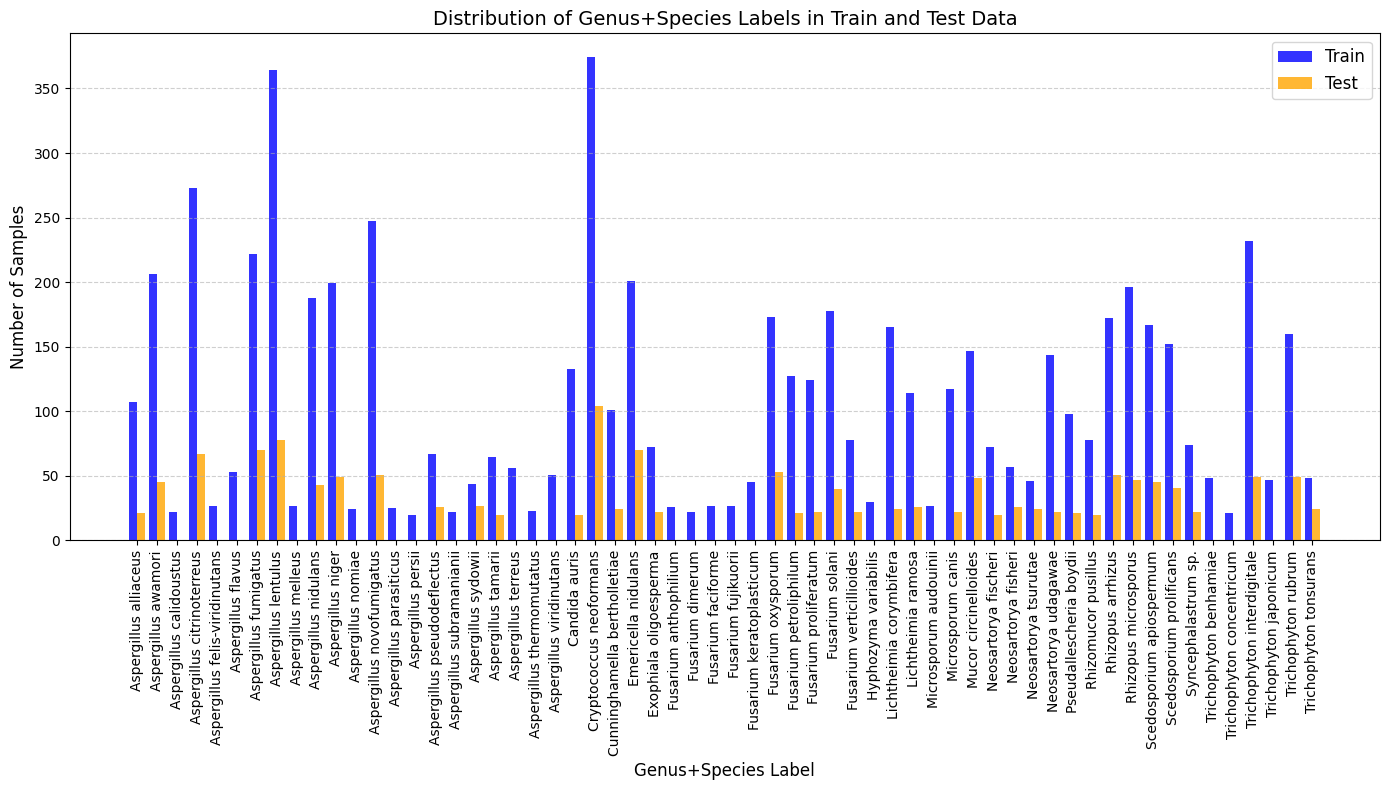

In [12]:
fungus_identifier.plot_data_distribution()

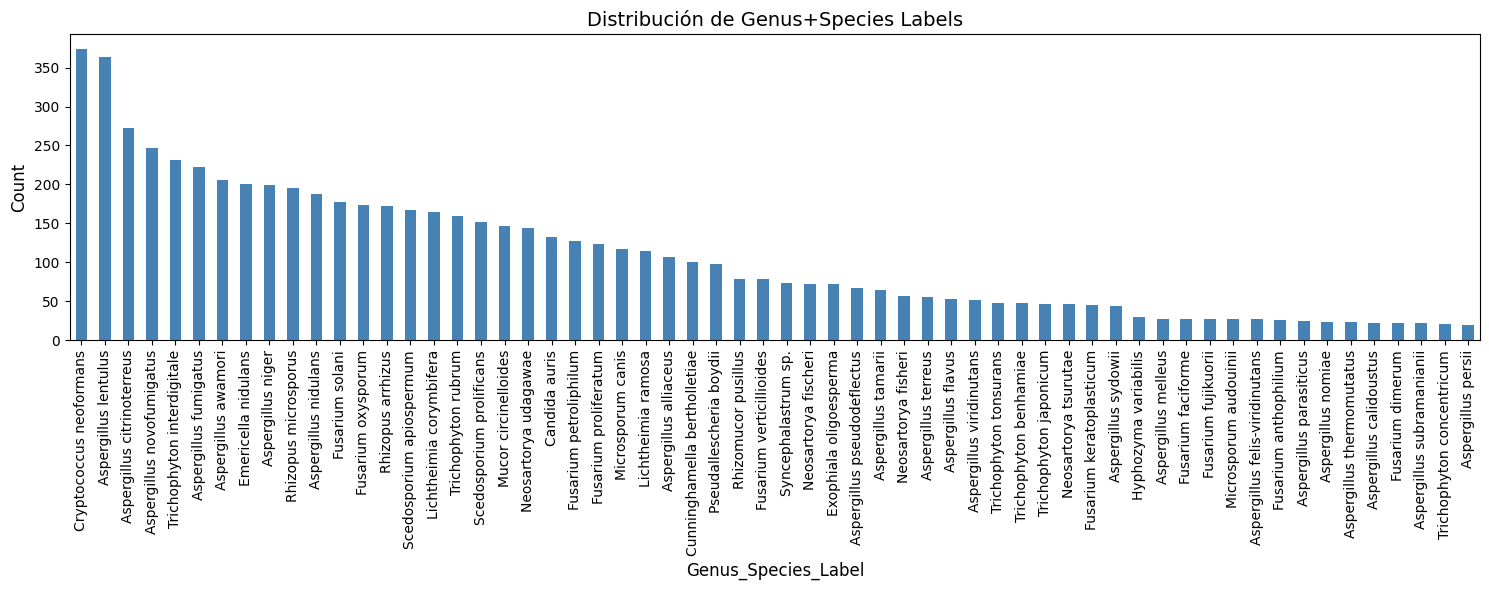

In [13]:
# Crear el gráfico de barras
plt.figure(figsize=(15, 6))  # Ajustar el tamaño del gráfico
fungus_identifier.train_data['genus_species_label'].value_counts().plot(kind='bar', color='steelblue')

# Rotar las etiquetas del eje X para que no se solapen
plt.xticks(rotation=90, fontsize=10)  # Rotar 90 grados y ajustar el tamaño de fuente

# Agregar etiquetas y título
plt.xlabel('Genus_Species_Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribución de Genus+Species Labels', fontsize=14)

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()

# Mostrar el gráfico
plt.show()


<Axes: xlabel='genus_label'>

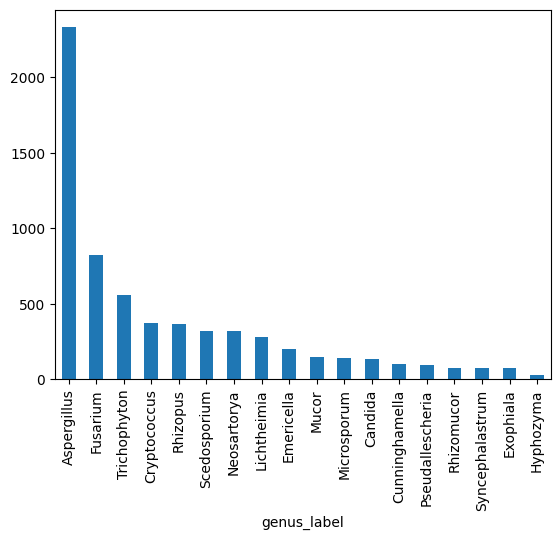

In [14]:
fungus_identifier.train_data['genus_label'].value_counts().plot(kind='bar')

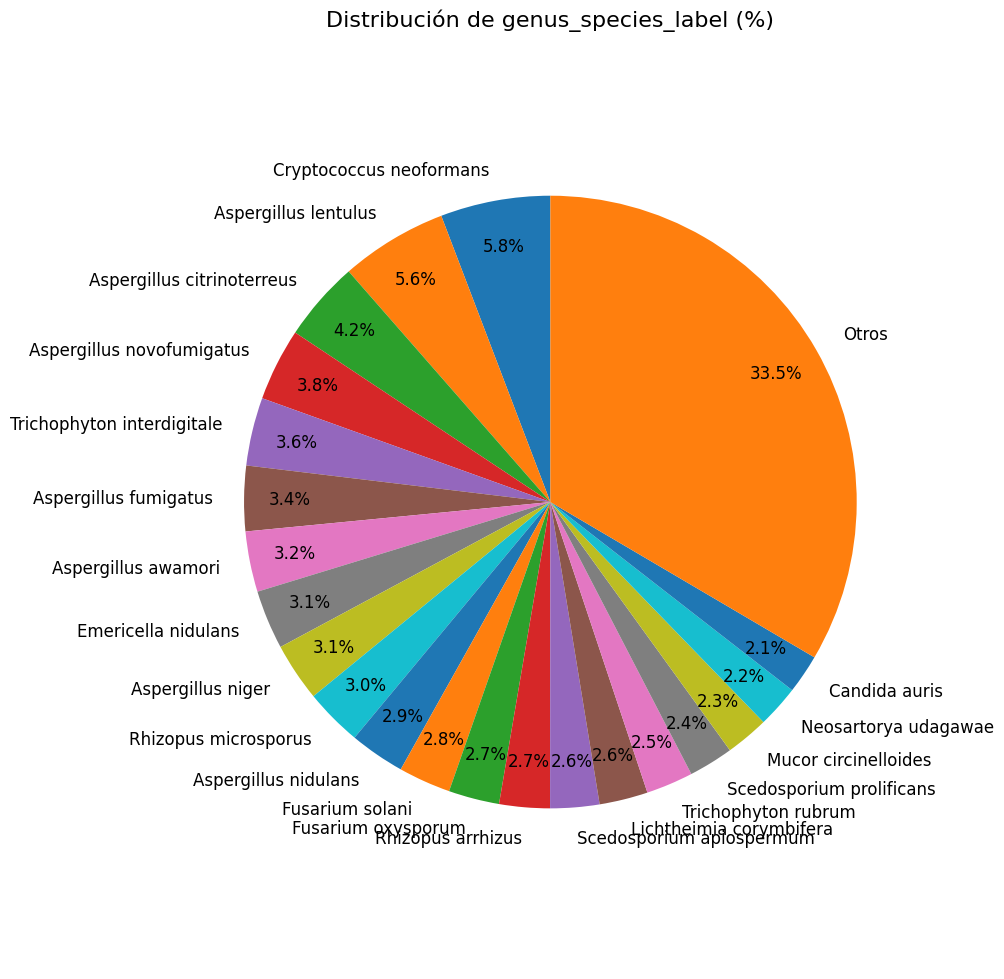

In [15]:
# Calcular los conteos y porcentajes
value_counts = fungus_identifier.train_data['genus_species_label'].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Agrupar categorías pequeñas
threshold = 2  # Porcentaje mínimo para mostrar individualmente
large_categories = percentages[percentages >= threshold]
small_categories = percentages[percentages < threshold].sum()
percentages_filtered = pd.concat([large_categories, pd.Series({'Otros': small_categories})])

# Crear el gráfico circular con líneas de conexión
plt.figure(figsize=(10, 10))  # Aumentar el tamaño del gráfico
plt.pie(
    percentages_filtered,
    labels=percentages_filtered.index,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12},
    pctdistance=0.85,  # Porcentajes más cerca del centro
    labeldistance=1.1  # Etiquetas más alejadas del centro
)
plt.title('Distribución de genus_species_label (%)', fontsize=16)
plt.axis('equal')  # Asegurar que el gráfico sea circular
plt.tight_layout()  # Ajustar elementos automáticamente
plt.show()

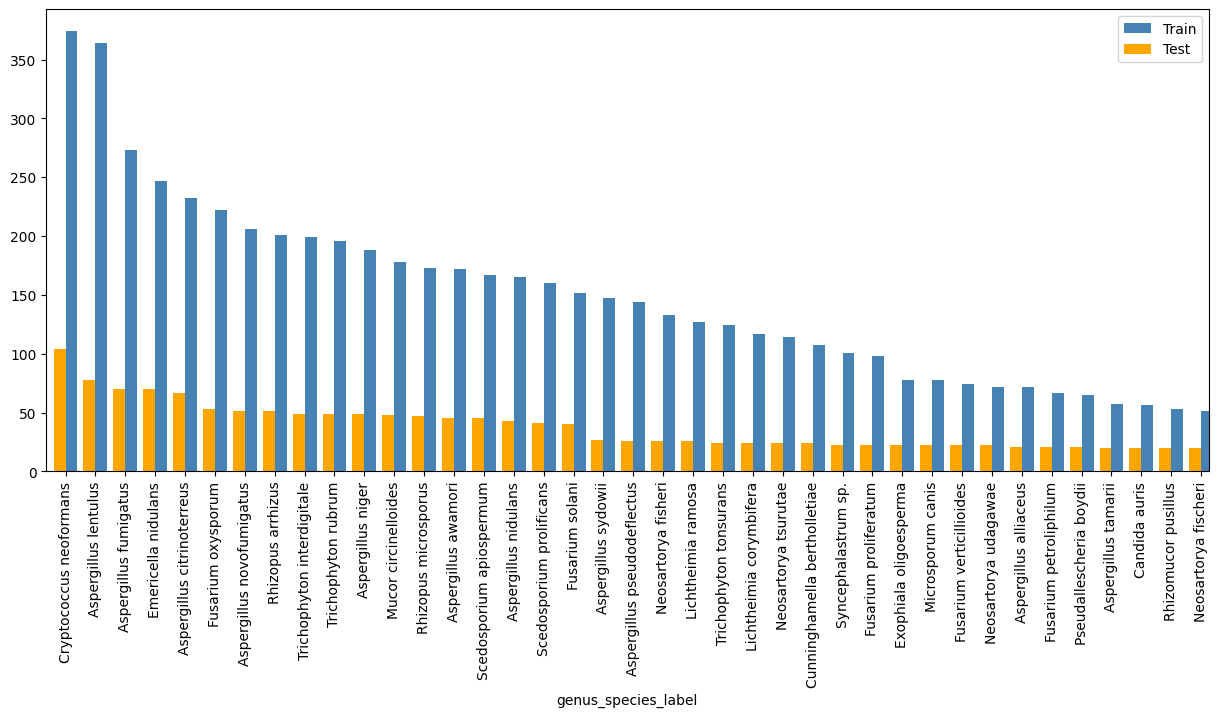

In [16]:
#Comparar la distribución de las etiquetas en los conjuntos de entrenamiento y prueba
plt.figure(figsize=(15, 6))  # Ajustar el tamaño del gráfico
fungus_identifier.train_data['genus_species_label'].value_counts().plot(kind='bar', color='steelblue', position=0, width=0.4, label='Train')
fungus_identifier.test_data['genus_species_label'].value_counts().plot(kind='bar', color='orange', position=1, width=0.4, label='Test')
plt.legend()

# Preprocesamiento de datos

In [87]:
train_data = fungus_identifier.get_train_data()
test_data = fungus_identifier.get_test_data()
print(f"Test data shape: {test_data.shape}")
print(f"Train data shape: {train_data.shape}")

Test data shape: (1476, 5)
Train data shape: (6452, 5)


## Codificando numéricamente las etiquetas

In [88]:
label_encoder_genus = LabelEncoder()
label_encoder_genus_species = LabelEncoder()

X = train_data.drop(columns=['genus_species_label', 'genus_label'])
y_species = label_encoder_genus_species.fit_transform(train_data['genus_species_label'])
y_genus = label_encoder_genus.fit_transform(train_data['genus_label'])

## Eliminando columnas m/z y unique_id_label

### Creando transformador personalizado para eliminar las columnas innecesarias

In [ ]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    """
    Transformer que elimina columnas por nombre.
    """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Se espera un pandas DataFrame
        return X.drop(columns=self.columns, errors='ignore')

## Creando una columna para cada valor del espectro

In [71]:
train_data['spectrum']

0       [0.0022636201918124353, 0.005722074038838838, ...
1       [0.002091315749178803, 0.005813570452719158, 0...
2       [0.0014357667301073194, 0.004573081526006474, ...
3       [0.0018279853432873092, 0.004338944188615056, ...
4       [0.0022844036693913756, 0.004587857169049415, ...
                              ...                        
7923    [0.0011182555270965102, 0.00039615825535114265...
7924    [0.0012396259113391249, 0.0004009885173193131,...
7925    [0.001023758266228797, 0.00044711285995063154,...
7926    [0.0013665472584009737, 0.00042831639487453263...
7927    [0.0011755108619971168, 0.0005719858038600177,...
Name: spectrum, Length: 6452, dtype: object

### Creando un transformador personalizado que se encargue de hacer esta operación en el pipeline

In [ ]:
class SpectrumExpander(BaseEstimator, TransformerMixin):
    """
    Transforma X de DataFrame con una columna 'spectrum' (listas/ndarrays)
    en un DataFrame donde se ocupa cada posición de 'spectrum' como una
    columna numérica separada y se elimina la columna original.
    """
    def __init__(self, spectrum_col: str = "spectrum"):
        self.spectrum_col = spectrum_col

    def fit(self, X, y=None):
        # No hay nada que aprender
        return self

    def transform(self, X):
        # Asumimos X es un DataFrame de pandas
        # 1) Expandir la columna spectrum en un DF de columnas numéricas
        spec = pd.DataFrame(
            X[self.spectrum_col].tolist(),
            index=X.index,
            columns=[f"spectrum_{i}" for i in range(len(X.iloc[0, :][self.spectrum_col]))]
        )
        # 2) Concatenar y eliminar la columna original
        X_expanded = pd.concat([X.drop(columns=[self.spectrum_col]), spec], axis=1)
        return X_expanded

## Escalado de los datos

### Creando transformador personalizado para el escalado

In [ ]:
class IntensityScaler(BaseEstimator, TransformerMixin):
    """
    Multiplica todas las columnas numéricas
    de entrada por un factor fijo.
    """
    def __init__(self, factor=1e4):
        self.factor = factor

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X * self.factor

## Estandarización de los datos por muestra

### Creando transformador personalizado para la estandarización por muestra

In [ ]:
class TICLogTransformer(BaseEstimator, TransformerMixin):
    """
    Normaliza cada fila por su suma (TIC) y luego aplica log1p.
    X puede ser DataFrame o array; la salida es del mismo tipo.
    """
    def __init__(self, eps: float = 1e-8):
        self.eps = eps

    def fit(self, X, y=None):
        # No aprende nada
        return self

    def transform(self, X):
        # Si recibimos numpy, lo convertimos a DataFrame para usar div(axis=0)
        is_df = isinstance(X, pd.DataFrame)
        if not is_df:
            X = pd.DataFrame(X)
        # 1) TIC: divide cada valor por la suma de su fila (más eps)
        tic = X.div(X.sum(axis=1) + self.eps, axis=0)
        # 2) log1p
        out = np.log1p(tic)
        # Si era array, devolvemos array; si DataFrame, devolvemos DataFrame con mismos index/cols
        if not is_df:
            return out.values
        out.index, out.columns = X.index, X.columns
        return out

## Estandarización por feature

### Probando una batería de modelos para decidir si estandarizamos por feature o no

In [ ]:
preproc = Pipeline([
    ('drop_cols',       ColumnDropper(['m/z', 'unique_id_label', 'genus_label','genus_species_label'])),
    ('spectrum_expand', SpectrumExpander('spectrum')),
    ('intensity_scale', IntensityScaler(factor=1e4)),
    ('tic_log',         TICLogTransformer(eps=1e-8)),
])

y = y_species

base_models = {
    "KNN"         : KNeighborsClassifier(n_neighbors=5),
    "LinearSVC"   : LinearSVC(dual=False),
    "RandomForest": RandomForestClassifier(n_jobs=-1),
    "HistGB"      : HistGradientBoostingClassifier(max_depth=3, learning_rate=0.1),
    "GaussianNB"  : GaussianNB()
}

In [ ]:
models_only = {}
models_scaled = {}

for name, clf in base_models.items():
    # a) pipeline solo con tu preprocesado
    models_only[name] = Pipeline([
        ('preproc', preproc),
        ('clf',     clf)
    ])
    # b) idem + escalado global de features antes del clasificador
    models_scaled[name] = Pipeline([
        ('preproc', preproc),
        ('scaler',  StandardScaler()),
        ('clf',     clf)
    ])

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(model_dict, X, y, cv, tag):
    print(f"\n=== {tag} ===")
    results = {}
    for name, model in model_dict.items():
        scores = cross_val_score(
            model, X, y,
            cv=cv,
            scoring="f1_macro",
            n_jobs=-1,
            verbose=1
        )
        mean, std = scores.mean(), scores.std()
        results[name] = (mean, std)
        print(f"{name:12s}  F1_macro = {mean:.3f} ± {std:.3f}")
    return results

In [ ]:
res_only   = evaluate(models_only,   X, y, cv, "TIC+log (solo sample‑wise)")
res_scaled = evaluate(models_scaled, X, y, cv, "TIC+log + StandardScaler(feature‑wise)")

Debido a los resultados vamos a usar estandarización por feature también por lo que la incorporaremos al pipeline

In [85]:
preproc = Pipeline([
    ('drop_cols',       ColumnDropper(['m/z', 'unique_id_label', 'genus_label','genus_species_label'])),
    ('spectrum_expand', SpectrumExpander('spectrum')),
    ('intensity_scale', IntensityScaler(factor=1e4)),
    ('tic_log',         TICLogTransformer(eps=1e-8)),
    ('std',         StandardScaler())
])

# Modelos clasicos

In [91]:
def evaluate_with_cross_validation(pipe, X_df, y, n_splits=6, random_state=42):
    """
    Evalúa un pipeline con StratifiedKFold, calculando métricas globales y por clase,
    y comprobando duplicados exactos entre train/test en cada fold.
    
    Parámetros
    ----------
    pipe       : Pipeline de sklearn (preproc + clf)
    X_df       : pandas.DataFrame con las features crudas
    y          : array‑like 1D de etiquetas codificadas
    n_splits   : int, número de folds
    random_state : semilla para reproducibilidad
    
    Devuelve
    -------
    df_global  : DataFrame con métricas globales por fold
    df_class   : DataFrame con métricas por clase por fold
    """
    cv = StratifiedKFold(n_splits=n_splits,
                         shuffle=True,
                         random_state=random_state)
    
    # Preparar estructuras
    global_metrics = []
    per_class      = []
    
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_df, y), start=1):
        # 1) Chequeo de índices
        assert set(train_idx).isdisjoint(test_idx), \
            f"Fold {fold}: overlap de índices!"
        
        # 3) Extraer splits como DataFrame/array
        X_train = X_df.iloc[train_idx]
        X_test  = X_df.iloc[test_idx]
        y_train = y[train_idx]
        y_test  = y[test_idx]
        
        # 4) Ajustar pipeline y predecir
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        # 5) Métricas globales
        global_metrics.append({
            "fold":             fold,
            "accuracy":         accuracy_score(y_test, y_pred),
            "precision_macro":  precision_score(y_test, y_pred, average="macro", zero_division=0),
            "recall_macro":     recall_score(y_test, y_pred, average="macro", zero_division=0),
            "f1_macro":         f1_score(y_test, y_pred, average="macro", zero_division=0),
            "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        })
        
        # 6) Métricas por clase
        report = classification_report(
            y_test, y_pred, output_dict=True, zero_division=0
        )
        for cls, m in report.items():
            if cls in ("accuracy", "macro avg", "weighted avg"):
                continue
            per_class.append({
                "fold":     fold,
                "class":    cls,
                "precision": m["precision"],
                "recall":    m["recall"],
                "f1":        m["f1-score"],
                "support":   m["support"]
            })
        
        # 7) Opcional: muestra el report texto de este fold
        print(f"\n--- Fold {fold} ---")
        print(classification_report(y_test, y_pred, zero_division=0))
    
    # 8) DataFrames finales
    df_global = pd.DataFrame(global_metrics).set_index("fold")
    df_class  = pd.DataFrame(per_class)
    
    # 9) Resúmenes
    print("\nMétricas globales por fold:")
    print(df_global)
    print("\nResumen global (media ± std):")
    print(df_global.agg(["mean","std"]))
    print("\nMétricas por clase (media ± std sobre folds):")
    print(
        df_class
          .groupby("class")[["precision","recall","f1"]]
          .agg(["mean","std"])
    )
    
    return df_global, df_class


## KNNClassifier

### Aleatorio

In [35]:
knn_classifier = KNeighborsClassifier()
knn_pipeline = Pipeline([
    ('preproc', preproc),
    ('clf', knn_classifier)
]
)
x_df = train_data.copy()
print(type(x_df))
evaluate_with_cross_validation(knn_pipeline, x_df, y_species, n_splits=6, random_state=42)

<class 'pandas.core.frame.DataFrame'>

--- Fold 1 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00        46
           4       0.80      1.00      0.89         4
           5       1.00      1.00      1.00         9
           6       1.00      0.97      0.99        37
           7       1.00      1.00      1.00        61
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00        32
          10       1.00      1.00      1.00        33
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00        41
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         3
          15       1.00      0.83      0.91        12
          16       1.00    

(      accuracy  precision_macro  recall_macro  f1_macro  balanced_accuracy
 fold                                                                      
 1     0.997212         0.996154      0.996772  0.996144           0.996772
 2     0.996283         0.998564      0.995749  0.996977           0.995749
 3     0.993488         0.991823      0.994717  0.991970           0.994717
 4     0.992558         0.992617      0.993924  0.992567           0.993924
 5     0.994419         0.993435      0.994126  0.992980           0.994126
 6     0.994419         0.995441      0.987735  0.989827           0.987735,
      fold class  precision  recall        f1  support
 0       1     0        1.0     1.0  1.000000     18.0
 1       1     1        1.0     1.0  1.000000     35.0
 2       1     2        1.0     1.0  1.000000      3.0
 3       1     3        1.0     1.0  1.000000     46.0
 4       1     4        0.8     1.0  0.888889      4.0
 ..    ...   ...        ...     ...       ...      ...
 355  

## Random Forest

### Aleatorio

In [93]:
random_forest_classifier = RandomForestClassifier(n_jobs=-1)
rf_pipeline = Pipeline([
    ('preproc', preproc),
    ('clf', random_forest_classifier)
]
)
evaluate_with_cross_validation(rf_pipeline, x_df, y_species, n_splits=6, random_state=42)


--- Fold 1 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        35
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00        46
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00        37
           7       1.00      1.00      1.00        61
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00        32
          10       1.00      1.00      1.00        33
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00        41
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00         3
          1

(      accuracy  precision_macro  recall_macro  f1_macro  balanced_accuracy
 fold                                                                      
 1          1.0              1.0           1.0       1.0                1.0
 2          1.0              1.0           1.0       1.0                1.0
 3          1.0              1.0           1.0       1.0                1.0
 4          1.0              1.0           1.0       1.0                1.0
 5          1.0              1.0           1.0       1.0                1.0
 6          1.0              1.0           1.0       1.0                1.0,
      fold class  precision  recall   f1  support
 0       1     0        1.0     1.0  1.0     18.0
 1       1     1        1.0     1.0  1.0     35.0
 2       1     2        1.0     1.0  1.0      3.0
 3       1     3        1.0     1.0  1.0     46.0
 4       1     4        1.0     1.0  1.0      4.0
 ..    ...   ...        ...     ...  ...      ...
 355     6    55        1.0     1.0  1.0 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib

# Create the pipeline with StandardScaler
rf_pipeline = make_pipeline(StandardScaler(), random_forest_classifier)

# Fit the model with the training data
rf_pipeline.fit(x_train, y_species_train)

# Save the model to a file
joblib.dump(rf_pipeline, 'random_forest_model.pkl')

print("Random Forest model trained and saved to random_forest_model.pkl")

## LinearSVC

In [97]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px
from IPython.display import IFrame

# 1) Preprocesado de features usando tu pipeline
X_proc = preproc.fit_transform(train_data)

# 2) PCA a 3 componentes
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_proc)

# 3) DataFrame para graficar
df_vis = pd.DataFrame(X_pca, columns=['PC1','PC2','PC3'])
df_vis['genus']   = label_encoder_genus.inverse_transform(y_genus)
df_vis['species'] = label_encoder_genus_species.inverse_transform(y_species)

# 4) Grafico 3D interactivo – Género
fig_genus = px.scatter_3d(
    df_vis, x='PC1', y='PC2', z='PC3',
    color='genus',
    title='PCA 3D interactivo – Género',
    labels={'genus':'Género'}
)
fig_genus.show()

# 5) O si prefieres guardarlo como HTML y luego incrustarlo:
html_path = "pca_genus.html"
fig_genus.write_html(html_path, include_plotlyjs='cdn')
display(IFrame(html_path, width=800, height=600))

# 6) Mismo para Especie
fig_species = px.scatter_3d(
    df_vis, x='PC1', y='PC2', z='PC3',
    color='species',
    title='PCA 3D interactivo – Especie',
    labels={'species':'Especie'}
)
fig_species.show()
html_path2 = "pca_species.html"
fig_species.write_html(html_path2, include_plotlyjs='cdn')
display(IFrame(html_path2, width=800, height=600))


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

# Resto

In [22]:
# Get the numerical encoding for critical and high risk genus
genus_critical_encoded = label_encoder_genus.transform(genus_critical)
genus_high_encoded = label_encoder_genus.transform(genus_high)

# print the names and the encoded values of genus names
print("Critical genus:")
for genus, encoded in zip(genus_critical, genus_critical_encoded):
    print(f"{genus}: {encoded}")
print("\nHigh risk genus:")
for genus, encoded in zip(genus_high, genus_high_encoded):
    print(f"{genus}: {encoded}")

Critical genus:
Candida: 1
Cryptococcus: 2
Aspergillus: 0

High risk genus:
Mucor: 10
Fusarium: 6


In [24]:
# Create a function to get a comprehensive mapping from genus labels to genus names
def get_genus_mapping_with_labels():
    """
    Returns a dictionary mapping numeric labels to genus names
    and a list where index corresponds to the numeric label.
    """
    # Get all unique genus labels and their string names
    genus_map = {}
    for genus in label_encoder_genus.classes_:
        label = label_encoder_genus.transform([genus])[0]
        genus_map[label] = genus
    
    # Create a list where index position matches the label value
    max_label = max(genus_map.keys())
    genus_list = ["" for _ in range(max_label + 1)]
    
    for label, genus in genus_map.items():
        genus_list[label] = genus
    
    return genus_list

# Get the mapping list where index corresponds to the label
genus_mapping = get_genus_mapping_with_labels()

# Print the mapping in a nicely formatted way
print("Genus Label Mapping (Label → Genus Name):")
print("-" * 40)
for label, genus in enumerate(genus_mapping):
    print(f"Label {label}: {genus}")

Genus Label Mapping (Label → Genus Name):
----------------------------------------
Label 0: Aspergillus
Label 1: Candida
Label 2: Cryptococcus
Label 3: Cunninghamella
Label 4: Emericella
Label 5: Exophiala
Label 6: Fusarium
Label 7: Hyphozyma
Label 8: Lichtheimia
Label 9: Microsporum
Label 10: Mucor
Label 11: Neosartorya
Label 12: Pseudallescheria
Label 13: Rhizomucor
Label 14: Rhizopus
Label 15: Scedosporium
Label 16: Syncephalastrum
Label 17: Trichophyton


In [25]:
def create_fungus_genus_mapping():
    """
    Creates and returns a list of fungal genera, with indices corresponding to 
    their encoded labels in the dataset.
    
    Returns:
        list: List of fungal genera in the order of their numerical encoding
    """
    mapping = [
        "Aspergillus",
        "Candida",
        "Cryptococcus",
        "Cunninghamella",
        "Emericella",
        "Exophiala",
        "Fusarium",
        "Hyphozyma",
        "Lichtheimia",
        "Microsporum",
        "Mucor",
        "Neosartorya",
        "Pseudallescheria", 
        "Rhizomucor",
        "Rhizopus",
        "Scedosporium",
        "Syncephalastrum",
        "Trichophyton"
    ]
    
    # Print mapping for verification
    for i, genus in enumerate(mapping):
        print(f"Label {i}: {genus}")
        
    return mapping

# Create the mapping
fungus_genus_mapping = create_fungus_genus_mapping()

Label 0: Aspergillus
Label 1: Candida
Label 2: Cryptococcus
Label 3: Cunninghamella
Label 4: Emericella
Label 5: Exophiala
Label 6: Fusarium
Label 7: Hyphozyma
Label 8: Lichtheimia
Label 9: Microsporum
Label 10: Mucor
Label 11: Neosartorya
Label 12: Pseudallescheria
Label 13: Rhizomucor
Label 14: Rhizopus
Label 15: Scedosporium
Label 16: Syncephalastrum
Label 17: Trichophyton


In [23]:
# Create a function to count elements in train and test sets
def count_elements_in_sets(train_data, test_data, encoder, labels, level="genus"):
    """
    Count occurrences of specified labels in train and test sets
    
    Parameters:
    - train_data: DataFrame with training data
    - test_data: DataFrame with test data
    - encoder: LabelEncoder used to encode the labels
    - labels: List of labels to count
    - level: 'genus' or 'genus_species' to specify which column to use
    
    Returns:
    - DataFrame with counts for each label in train and test sets
    """
    column = "genus_label" if level == "genus" else "genus_species_label"
    
    # Convert labels to encoded values
    encoded_labels = []
    for label in labels:
        if label in encoder.classes_:
            encoded_labels.append(encoder.transform([label])[0])
    
    # Count occurrences
    results = []
    for label, encoded in zip(labels, encoded_labels):
        train_count = sum(train_data[column] == encoded)
        test_count = sum(test_data[column] == encoded)
        results.append({
            'Label': label,
            'Train Count': train_count,
            'Test Count': test_count,
            'Total': train_count + test_count
        })
    
    return pd.DataFrame(results)

# Count for critical and high risk genus
genus_critical_counts = count_elements_in_sets(
    train_data, test_data, label_encoder_genus, genus_critical, level="genus"
)
genus_high_counts = count_elements_in_sets(
    train_data, test_data, label_encoder_genus, genus_high, level="genus"
)

# Count for critical and high risk genus-species
genus_species_critical_counts = count_elements_in_sets(
    train_data, test_data, label_encoder_genus_species, genus_species_critical, level="genus_species"
)
genus_species_high_counts = count_elements_in_sets(
    train_data, test_data, label_encoder_genus_species, [sp for sp in genus_species_high if sp in label_encoder_genus_species.classes_], 
    level="genus_species"
)

# Display results with formatting
print("Critical Genus Distribution:")
print("-" * 60)
print(genus_critical_counts.to_string(index=False))
print("\nHigh Risk Genus Distribution:")
print("-" * 60)
print(genus_high_counts.to_string(index=False))
print("\nCritical Genus-Species Distribution:")
print("-" * 60)
print(genus_species_critical_counts.to_string(index=False))
print("\nHigh Risk Genus-Species Distribution:")
print("-" * 60)
print(genus_species_high_counts.to_string(index=False))

# Calculate totals for each risk category
critical_genus_total = genus_critical_counts['Total'].sum()
high_genus_total = genus_high_counts['Total'].sum()
critical_species_total = genus_species_critical_counts['Total'].sum()
high_species_total = genus_species_high_counts['Total'].sum()

print("\nSummary Statistics:")
print("-" * 60)
print(f"Total samples in critical genus: {critical_genus_total}")
print(f"Total samples in high risk genus: {high_genus_total}")
print(f"Total samples in critical genus-species: {critical_species_total}")
print(f"Total samples in high risk genus-species: {high_species_total}")
print(f"Percentage of critical genus samples: {critical_genus_total/(len(train_data)+len(test_data))*100:.2f}%")
print(f"Percentage of high risk genus samples: {high_genus_total/(len(train_data)+len(test_data))*100:.2f}%")

NameError: name 'genus_species_critical' is not defined

In [ ]:
# Create a corrected list for high_risk_genus_species that only includes species with samples in the test set
# Extract species names from genus_species_high_counts that have test samples
high_risk_genus_species_with_samples = [
    row['Label'] for _, row in genus_species_high_counts.iterrows() 
    if row['Test Count'] > 0
]

# Print the updated list
print("High risk species with samples in test set:")
for species in high_risk_genus_species_with_samples:
    print(f"- {species}")

# Count total samples in test set for these species
total_test_samples = sum(
    row['Test Count'] for _, row in genus_species_high_counts.iterrows() 
    if row['Test Count'] > 0
)
print(f"\nTotal high risk species samples in test set: {total_test_samples}")

# Check percentage of test data covered by these high risk species
test_coverage = total_test_samples / len(test_data) * 100
print(f"These species represent {test_coverage:.2f}% of the test dataset")

High risk species with samples in test set:
- Mucor circinelloides
- Fusarium oxysporum
- Fusarium petroliphilum
- Fusarium proliferatum
- Fusarium solani
- Fusarium verticillioides

Total high risk species samples in test set: 206
These species represent 13.96% of the test dataset


In [ ]:
# Create a function to map labels to their numerical encodings
def print_species_with_labels(species_list, encoder, label_type="Species"):
    """
    Prints species names with their corresponding numerical labels
    
    Parameters:
    - species_list: List of species names
    - encoder: LabelEncoder used for encoding
    - label_type: String to describe the type of label (for printing)
    """
    print(f"\n{label_type} labels:")
    print("-" * 50)
    
    for species in species_list:
        if species in encoder.classes_:
            label = encoder.transform([species])[0]
            print(f"{species.ljust(30)} | Label: {label}")
        else:
            print(f"{species.ljust(30)} | Not in dataset")
    print("-" * 50)

# Print genus critical and high risk with their labels
print_species_with_labels(genus_critical, label_encoder_genus, "Critical genera")
print_species_with_labels(genus_high, label_encoder_genus, "High risk genera")

# Print genus+species critical and high risk with their labels
print_species_with_labels(genus_species_critical, label_encoder_genus_species, "Critical species")
print_species_with_labels(high_risk_genus_species_with_samples, label_encoder_genus_species, "High risk species")


Critical genera labels:
--------------------------------------------------
Candida                        | Label: 1
Cryptococcus                   | Label: 2
Aspergillus                    | Label: 0
--------------------------------------------------

High risk genera labels:
--------------------------------------------------
Mucor                          | Label: 10
Fusarium                       | Label: 6
--------------------------------------------------

Critical species labels:
--------------------------------------------------
Candida auris                  | Label: 22
Cryptococcus neoformans        | Label: 23
Aspergillus fumigatus          | Label: 6
--------------------------------------------------

High risk species labels:
--------------------------------------------------
Mucor circinelloides           | Label: 42
Fusarium oxysporum             | Label: 32
Fusarium petroliphilum         | Label: 33
Fusarium proliferatum          | Label: 34
Fusarium solani             

In [ ]:
# Create a function to get the sorted list of fungal genera
def get_fungus_genus_mapping():
    """
    Returns a list of fungus genus names, where the index corresponds to the numeric label
    in the dataset.
    
    Returns:
        list: A list of fungus genus names in the order of their numeric encoding
    """
    # Get all unique genus names and their corresponding numeric labels
    genus_names = []
    for genus in label_encoder_genus.classes_:
        label = label_encoder_genus.transform([genus])[0]
        genus_names.append((label, genus))
    
    # Sort by the numeric label
    genus_names.sort(key=lambda x: x[0])
    
    # Extract just the genus names in the correct order
    genus_list = [name for _, name in genus_names]
    
    return genus_list

# Get the ordered list of fungus genera
fungus_genus_mapping = get_fungus_genus_mapping()

# Print the mapping with its corresponding index/label
for i, genus in enumerate(fungus_genus_mapping):
    print(f"Label {i}: {genus}")

NameError: name 'label_encoder_genus' is not defined

In [10]:
x_train = train_data.drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])
genus_label_train = train_data['genus_label']
genus_species_label_train = train_data['genus_species_label']
x_test = test_data.drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])
genus_label_test = test_data['genus_label']
genus_species_label_test = test_data['genus_species_label']

In [14]:
# Get all unique genus-species labels and their numeric encodings
unique_genus_species = list(set(train_data['genus_species_label'].tolist() + test_data['genus_species_label'].tolist()))
unique_genus_species.sort()  # Sort by the numeric label

# Get original string labels for each numeric label
genus_species_mapping = {}
for species in label_encoder_genus_species.classes_:
    numeric_label = label_encoder_genus_species.transform([species])[0]
    genus_species_mapping[numeric_label] = species

# Create a DataFrame to display in sorted order
mapping_df = pd.DataFrame({
    'Numeric Label': sorted(unique_genus_species),
    'Genus-Species': [genus_species_mapping[label] for label in sorted(unique_genus_species)]
})

# Display the mapping
print("Genus-Species Labels and their Numeric Encodings:")
print("-" * 60)
print(mapping_df.to_string(index=False))

# Count samples for each class in train and test sets
train_counts = train_data['genus_species_label'].value_counts().sort_index()
test_counts = test_data['genus_species_label'].value_counts().sort_index()

# Create a comprehensive DataFrame with counts
count_data = []
for label in sorted(unique_genus_species):
    species_name = genus_species_mapping[label]
    train_count = train_counts.get(label, 0)
    test_count = test_counts.get(label, 0)
    total = train_count + test_count
    count_data.append({
        'Label': label,
        'Genus-Species': species_name,
        'Train Count': train_count,
        'Test Count': test_count,
        'Total': total
    })

# Convert to DataFrame and display
distribution_df = pd.DataFrame(count_data)
print("\n\nSample Distribution by Genus-Species:")
print("-" * 60)
print(distribution_df.to_string(index=False))

Genus-Species Labels and their Numeric Encodings:
------------------------------------------------------------
 Numeric Label                  Genus-Species
             0          Aspergillus alliaceus
             1            Aspergillus awamori
             2        Aspergillus calidoustus
             3     Aspergillus citrinoterreus
             4 Aspergillus felis-viridinutans
             5             Aspergillus flavus
             6          Aspergillus fumigatus
             7           Aspergillus lentulus
             8            Aspergillus melleus
             9           Aspergillus nidulans
            10              Aspergillus niger
            11             Aspergillus nomiae
            12      Aspergillus novofumigatus
            13        Aspergillus parasiticus
            14             Aspergillus persii
            15    Aspergillus pseudodeflectus
            16      Aspergillus subramanianii
            17            Aspergillus sydowii
            18 

In [15]:
def get_fungus_species_mapping():
    """
    Returns a list of fungus species names, where the index corresponds to the numeric label
    in the dataset.
    
    Returns:
        list: A list of fungus species names in the order of their numeric encoding
    """
    species_list = [
        'Aspergillus alliaceus',
        'Aspergillus awamori',
        'Aspergillus calidoustus',
        'Aspergillus citrinoterreus',
        'Aspergillus felis-viridinutans',
        'Aspergillus flavus',
        'Aspergillus fumigatus',
        'Aspergillus lentulus',
        'Aspergillus melleus',
        'Aspergillus nidulans',
        'Aspergillus niger',
        'Aspergillus nomiae',
        'Aspergillus novofumigatus',
        'Aspergillus parasiticus',
        'Aspergillus persii',
        'Aspergillus pseudodeflectus',
        'Aspergillus subramanianii',
        'Aspergillus sydowii',
        'Aspergillus tamarii',
        'Aspergillus terreus',
        'Aspergillus thermomutatus',
        'Aspergillus viridinutans',
        'Candida auris',
        'Cryptococcus neoformans',
        'Cunninghamella bertholletiae',
        'Emericella nidulans',
        'Exophiala oligoesperma',
        'Fusarium anthophilium',
        'Fusarium dimerum',
        'Fusarium faciforme',
        'Fusarium fujikuorii',
        'Fusarium keratoplasticum',
        'Fusarium oxysporum',
        'Fusarium petroliphilum',
        'Fusarium proliferatum',
        'Fusarium solani',
        'Fusarium verticillioides',
        'Hyphozyma variabilis',
        'Lichtheimia corymbifera',
        'Lichtheimia ramosa',
        'Microsporum audouinii',
        'Microsporum canis',
        'Mucor circinelloides',
        'Neosartorya fischeri',
        'Neosartorya fisheri',
        'Neosartorya tsurutae',
        'Neosartorya udagawae',
        'Pseudallescheria boydii',
        'Rhizomucor pusillus',
        'Rhizopus arrhizus',
        'Rhizopus microsporus',
        'Scedosporium apiospermum',
        'Scedosporium prolificans',
        'Syncephalastrum sp.',
        'Trichophyton benhamiae',
        'Trichophyton concentricum',
        'Trichophyton interdigitale',
        'Trichophyton japonicum',
        'Trichophyton rubrum',
        'Trichophyton tonsurans'
    ]
    
    return species_list

# Get the mapping of fungus species
fungus_species_mapping = get_fungus_species_mapping()
for specie in fungus_species_mapping:
    #get the numeric label for each species
    numeric_label = label_encoder_genus_species.transform([specie])[0]
    print(f"Species: {specie}, Numeric Label: {numeric_label}")

Species: Aspergillus alliaceus, Numeric Label: 0
Species: Aspergillus awamori, Numeric Label: 1
Species: Aspergillus calidoustus, Numeric Label: 2
Species: Aspergillus citrinoterreus, Numeric Label: 3
Species: Aspergillus felis-viridinutans, Numeric Label: 4
Species: Aspergillus flavus, Numeric Label: 5
Species: Aspergillus fumigatus, Numeric Label: 6
Species: Aspergillus lentulus, Numeric Label: 7
Species: Aspergillus melleus, Numeric Label: 8
Species: Aspergillus nidulans, Numeric Label: 9
Species: Aspergillus niger, Numeric Label: 10
Species: Aspergillus nomiae, Numeric Label: 11
Species: Aspergillus novofumigatus, Numeric Label: 12
Species: Aspergillus parasiticus, Numeric Label: 13
Species: Aspergillus persii, Numeric Label: 14
Species: Aspergillus pseudodeflectus, Numeric Label: 15
Species: Aspergillus subramanianii, Numeric Label: 16
Species: Aspergillus sydowii, Numeric Label: 17
Species: Aspergillus tamarii, Numeric Label: 18
Species: Aspergillus terreus, Numeric Label: 19
Spe

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def evaluate_knn_classifier(x_test, y_test, knn_classifier, classes=None, figsize=(20, 20), fontsize=8, zero_division=0):
    """
    Evalúa un clasificador KNN en datos de prueba e incluye métricas detalladas,
    además de graficar la matriz de confusión sin la barra de color (colorbar).
    """
    # Predicciones del clasificador
    y_pred = knn_classifier.predict(x_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    print(f"KNN Classifier Accuracy: {accuracy:.2f}")
    
    print("\nClassification Report:")
    print(
        classification_report(
            y_test, 
            y_pred, 
            target_names=classes, 
            zero_division=zero_division  # Evitar el warning
        )
    )
    
    # Generar la matriz de confusión (solo con las clases presentes en y_test e y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Obtener etiquetas reales del clasificador (todas las clases vistas en el entrenamiento)
    real_class_labels = knn_classifier.classes_
    
    # Identificar las clases presentes en el conjunto de prueba/predicciones
    unique_classes_in_test = np.unique(np.concatenate((y_test, y_pred)))
    
    # Filtrar etiquetas reales para mostrar solo las clases presentes en la matriz de confusión
    display_labels = [str(label) for label in real_class_labels if label in unique_classes_in_test]
    
    # Graficar la matriz de confusión sin la barra de color
    fig, ax = plt.subplots(figsize=figsize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap="Blues", ax=ax, colorbar=False)  # Aquí desactivamos la barra de color
    
    # Ajustar etiquetas y título
    plt.xticks(fontsize=fontsize, rotation=90)
    plt.yticks(fontsize=fontsize)
    plt.title("Confusion Matrix", fontsize=fontsize + 4)
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'predicted_labels': y_pred,
        'true_labels': y_test
    }


# BASELINE: KNN

## KNN con n_neighbors aleatorio

In [14]:
spectrum = np.array(train_data['spectrum'].tolist())
knn_genus_level = KNeighborsClassifier(n_neighbors=5)
knn_genus_level.fit(spectrum, genus_label_train)
knn_genus_species_level = KNeighborsClassifier(n_neighbors=5)
knn_genus_species_level.fit(spectrum, genus_species_label_train)

KNeighborsClassifier()

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO -----------------------------------
KNN Classifier Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       497
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00       104
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        70
           5       1.00      1.00      1.00        22
           6       1.00      1.00      1.00       158
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        48
          11       1.00      0.50      0.67        92
          12       1.00      1.00      1.00        21
          13       0.00      0.00      0.00        20
          14       0.83      1.00      0.91        98
          15       1.00      1.00      1.

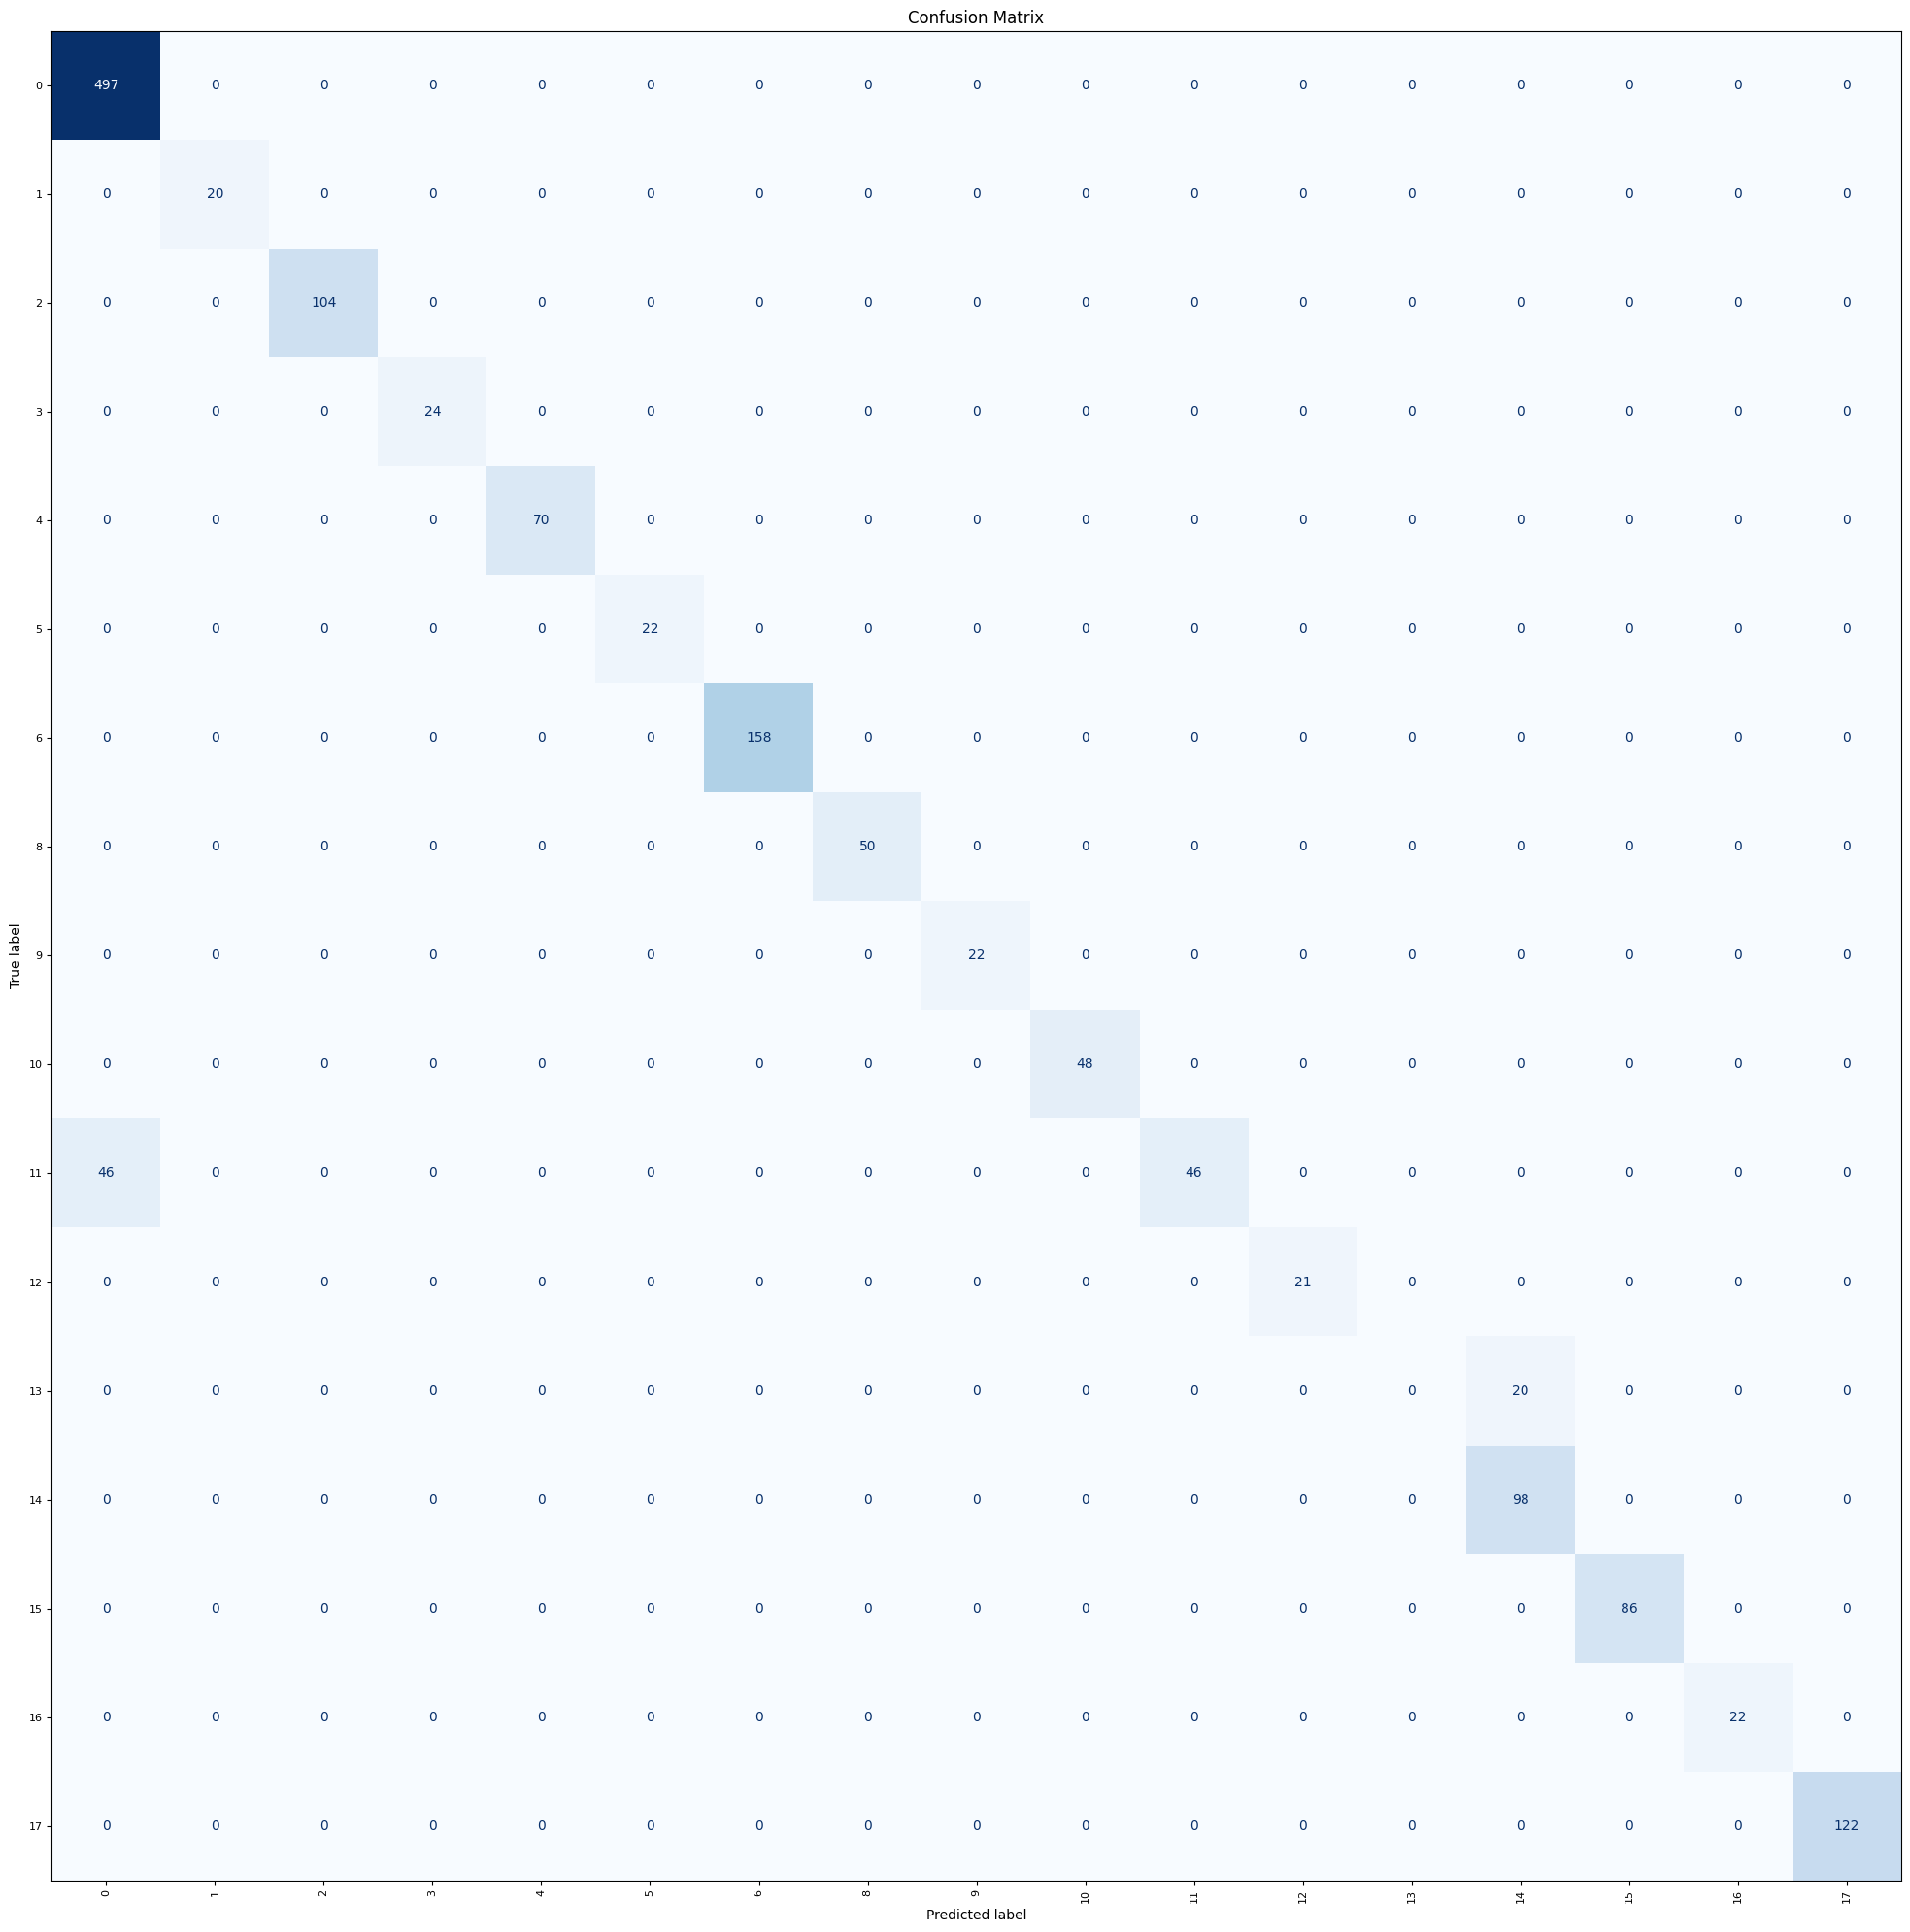

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE -----------------------------------
KNN Classifier Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.31      0.47        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        78
           9       1.00      1.00      1.00        43
          10       0.61      1.00      0.76        49
          12       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        26
          17       1.00      1.00      1.00        27
          18       1.00      1.00      1.00        20
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.00      1.

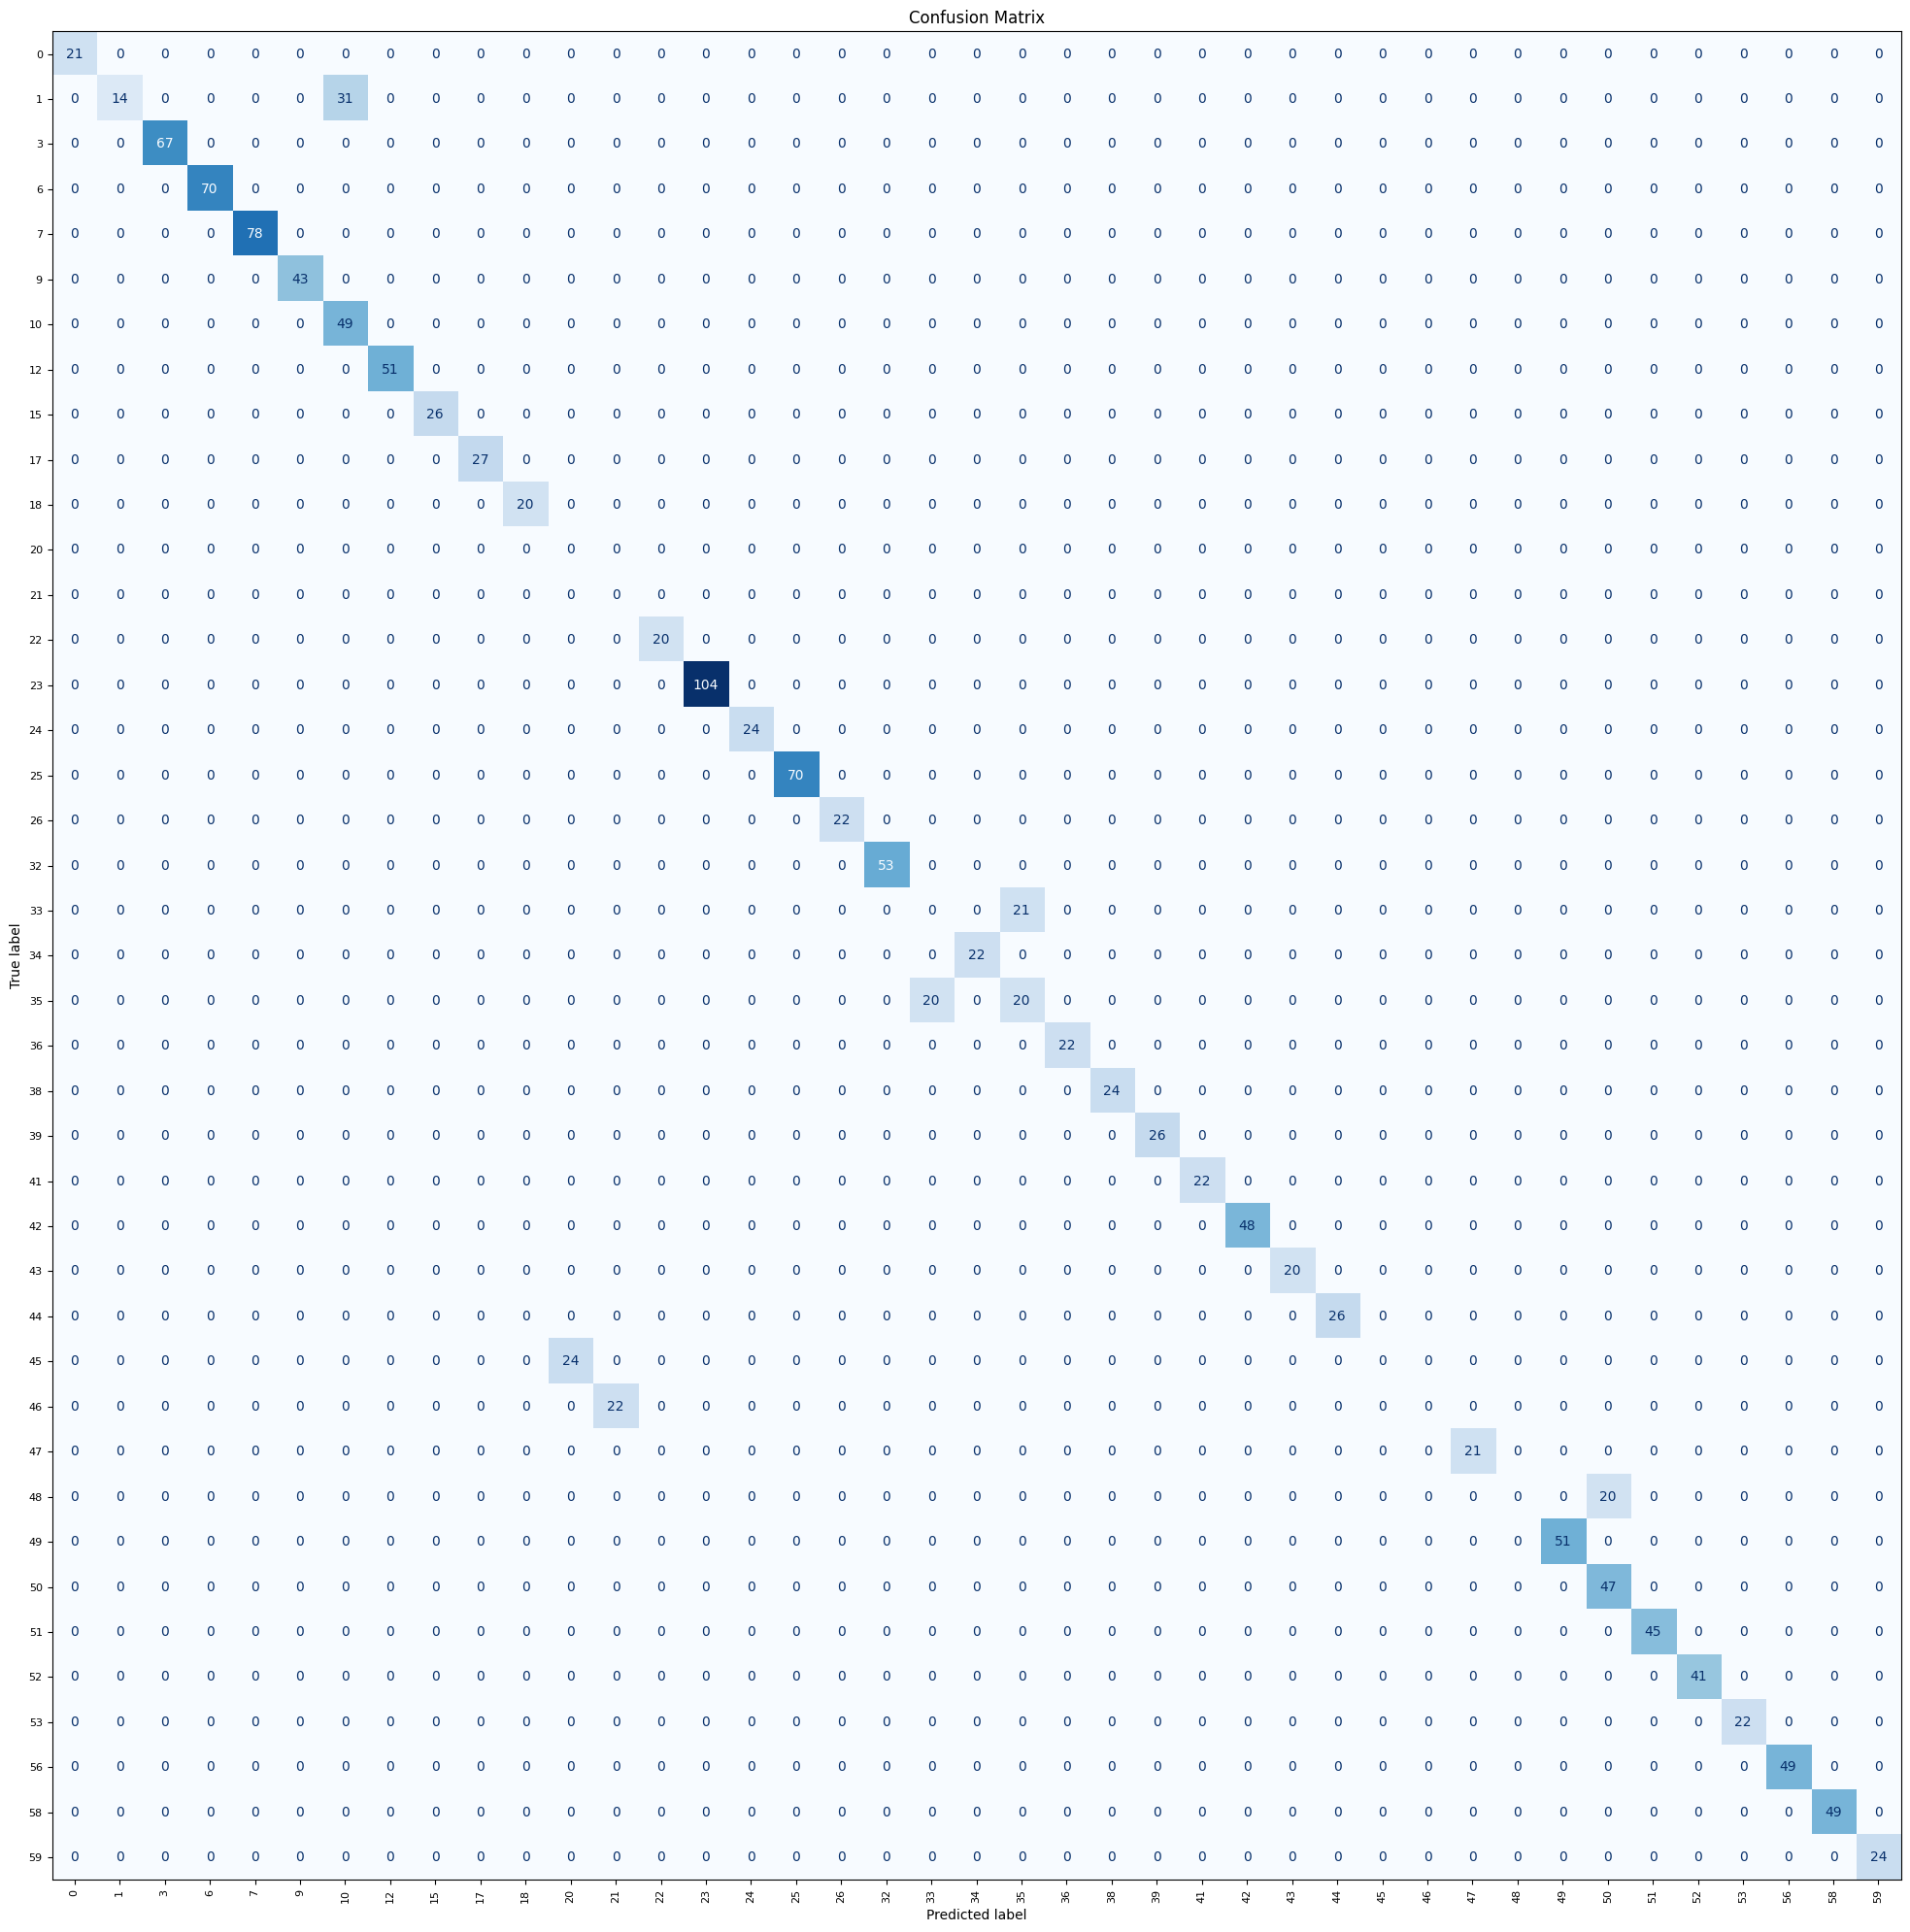

{'accuracy': 0.9065040650406504,
 'predicted_labels': array([ 0,  0,  0, ..., 59, 59, 59]),
 'true_labels': 86       0
 87       0
 88       0
 89       0
 90       0
         ..
 7875    59
 7876    59
 7877    59
 7878    59
 7879    59
 Name: genus_species_label, Length: 1476, dtype: int64}

In [15]:
spectrum_test = np.array(test_data['spectrum'].tolist())
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_label_test, knn_genus_level)
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_genus_species_level)

In [39]:
#Concatena spectrum y spectrum_test
spectrum_completo = np.concatenate((spectrum, spectrum_test), axis=0)
genus_label_completo = np.concatenate((genus_label_train, genus_label_test), axis=0)
genus_label_completo

array([ 0,  0,  0, ..., 17, 17, 17])

## Aplicando grid search en busca de los mejores híper parámetros

In [13]:
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto','ball_tree', 'brute']
}

In [ ]:
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=4,  # Validación cruzada
    scoring='accuracy',  # Métrica principal
    verbose=3,  # Mostrar progreso
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ajustar el modelo con los datos ya normalizados
grid_search.fit(spectrum, genus_species_label_train)

# Resultados del mejor modelo
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Score:", grid_search.best_score_)

In [124]:
joblib.dump(grid_search, "grid_search_knn.pkl")

['grid_search_knn.pkl']

In [128]:
knn_best = grid_search.best_estimator_
knn_best.fit(spectrum, genus_species_label_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [16]:
#cuenta el numero de Aspergillus fumigatus en el conjunto de test
id = label_encoder_genus_species.transform(['Aspergillus fumigatus'])[0]
count = Counter(genus_species_label_test)
print(f"Number of Aspergillus fumigatus in test set: {count[id]}")

Number of Aspergillus fumigatus in test set: 70


In [ ]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_best)

In [ ]:
knn_best = grid_search.best_estimator_
knn_best.fit(spectrum, genus_label_train)

In [ ]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_label_test, knn_best)

## Usando SMOTE

In [18]:
train_data_for_SMOTE = train_data.copy().drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])
test_data_for_SMOTE = test_data.copy().drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])

In [12]:
train_data_to_export = train_data.copy().drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])
test_data_to_export = test_data.copy().drop(columns=['genus_species_label', 'genus_label', 'unique_id_label','m/z'])
train_data_to_export.to_csv('train_data.csv', index=False)
test_data_to_export.to_csv('test_data.csv', index=False)
genus_species_label_train.to_csv('genus_species_label_train.csv', index=False)
genus_species_label_test.to_csv('genus_species_label_test.csv', index=False)
genus_label_test.to_csv('genus_label_test.csv', index=False)

In [19]:
spectrum_train_for_SMOTE = np.array(train_data_for_SMOTE['spectrum'].tolist())
smote = SMOTE(random_state=42)
x_train_smote, genus_species_smote = smote.fit_resample(spectrum_train_for_SMOTE, genus_species_label_train)

In [20]:
genus_species_smote_labels = label_encoder_genus_species.inverse_transform(genus_species_smote)
genus_smote_labels = [label.split()[0] for label in genus_species_smote_labels]
genus_smote = label_encoder_genus.transform(genus_smote_labels)

In [21]:
print(label_encoder_genus_species.transform(['Aspergillus fumigatus']))

[6]


In [22]:
#print correlations betwenn genus and his labels
print(label_encoder_genus.inverse_transform([6]))

['Fusarium']


In [23]:
knn_genus_species_level_smote = KNeighborsClassifier(n_neighbors=5)
knn_genus_species_level_smote.fit(x_train_smote, genus_species_smote)

KNeighborsClassifier()

In [24]:
import pandas as pd

pd.DataFrame(x_train_smote).to_csv('x_train_smote.csv', index=False)
pd.DataFrame(spectrum_test).to_csv('x_test_smote.csv', index=False)
pd.DataFrame(genus_species_smote).to_csv('genus_species_train_labels_smote.csv', index=False)
pd.DataFrame(genus_species_label_test).to_csv('genus_species_test_labels_smote.csv', index=False)
pd.DataFrame(genus_label_train).to_csv('genus_train_labels_smote.csv', index=False)
pd.DataFrame(genus_label_test).to_csv('genus_test_labels_smote.csv', index=False)


---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------
KNN Classifier Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.24      0.39        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        78
           9       1.00      1.00      1.00        43
          10       0.59      1.00      0.74        49
          12       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        26
          17       1.00      1.00      1.00        27
          18       1.00      1.00      1.00        20
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.

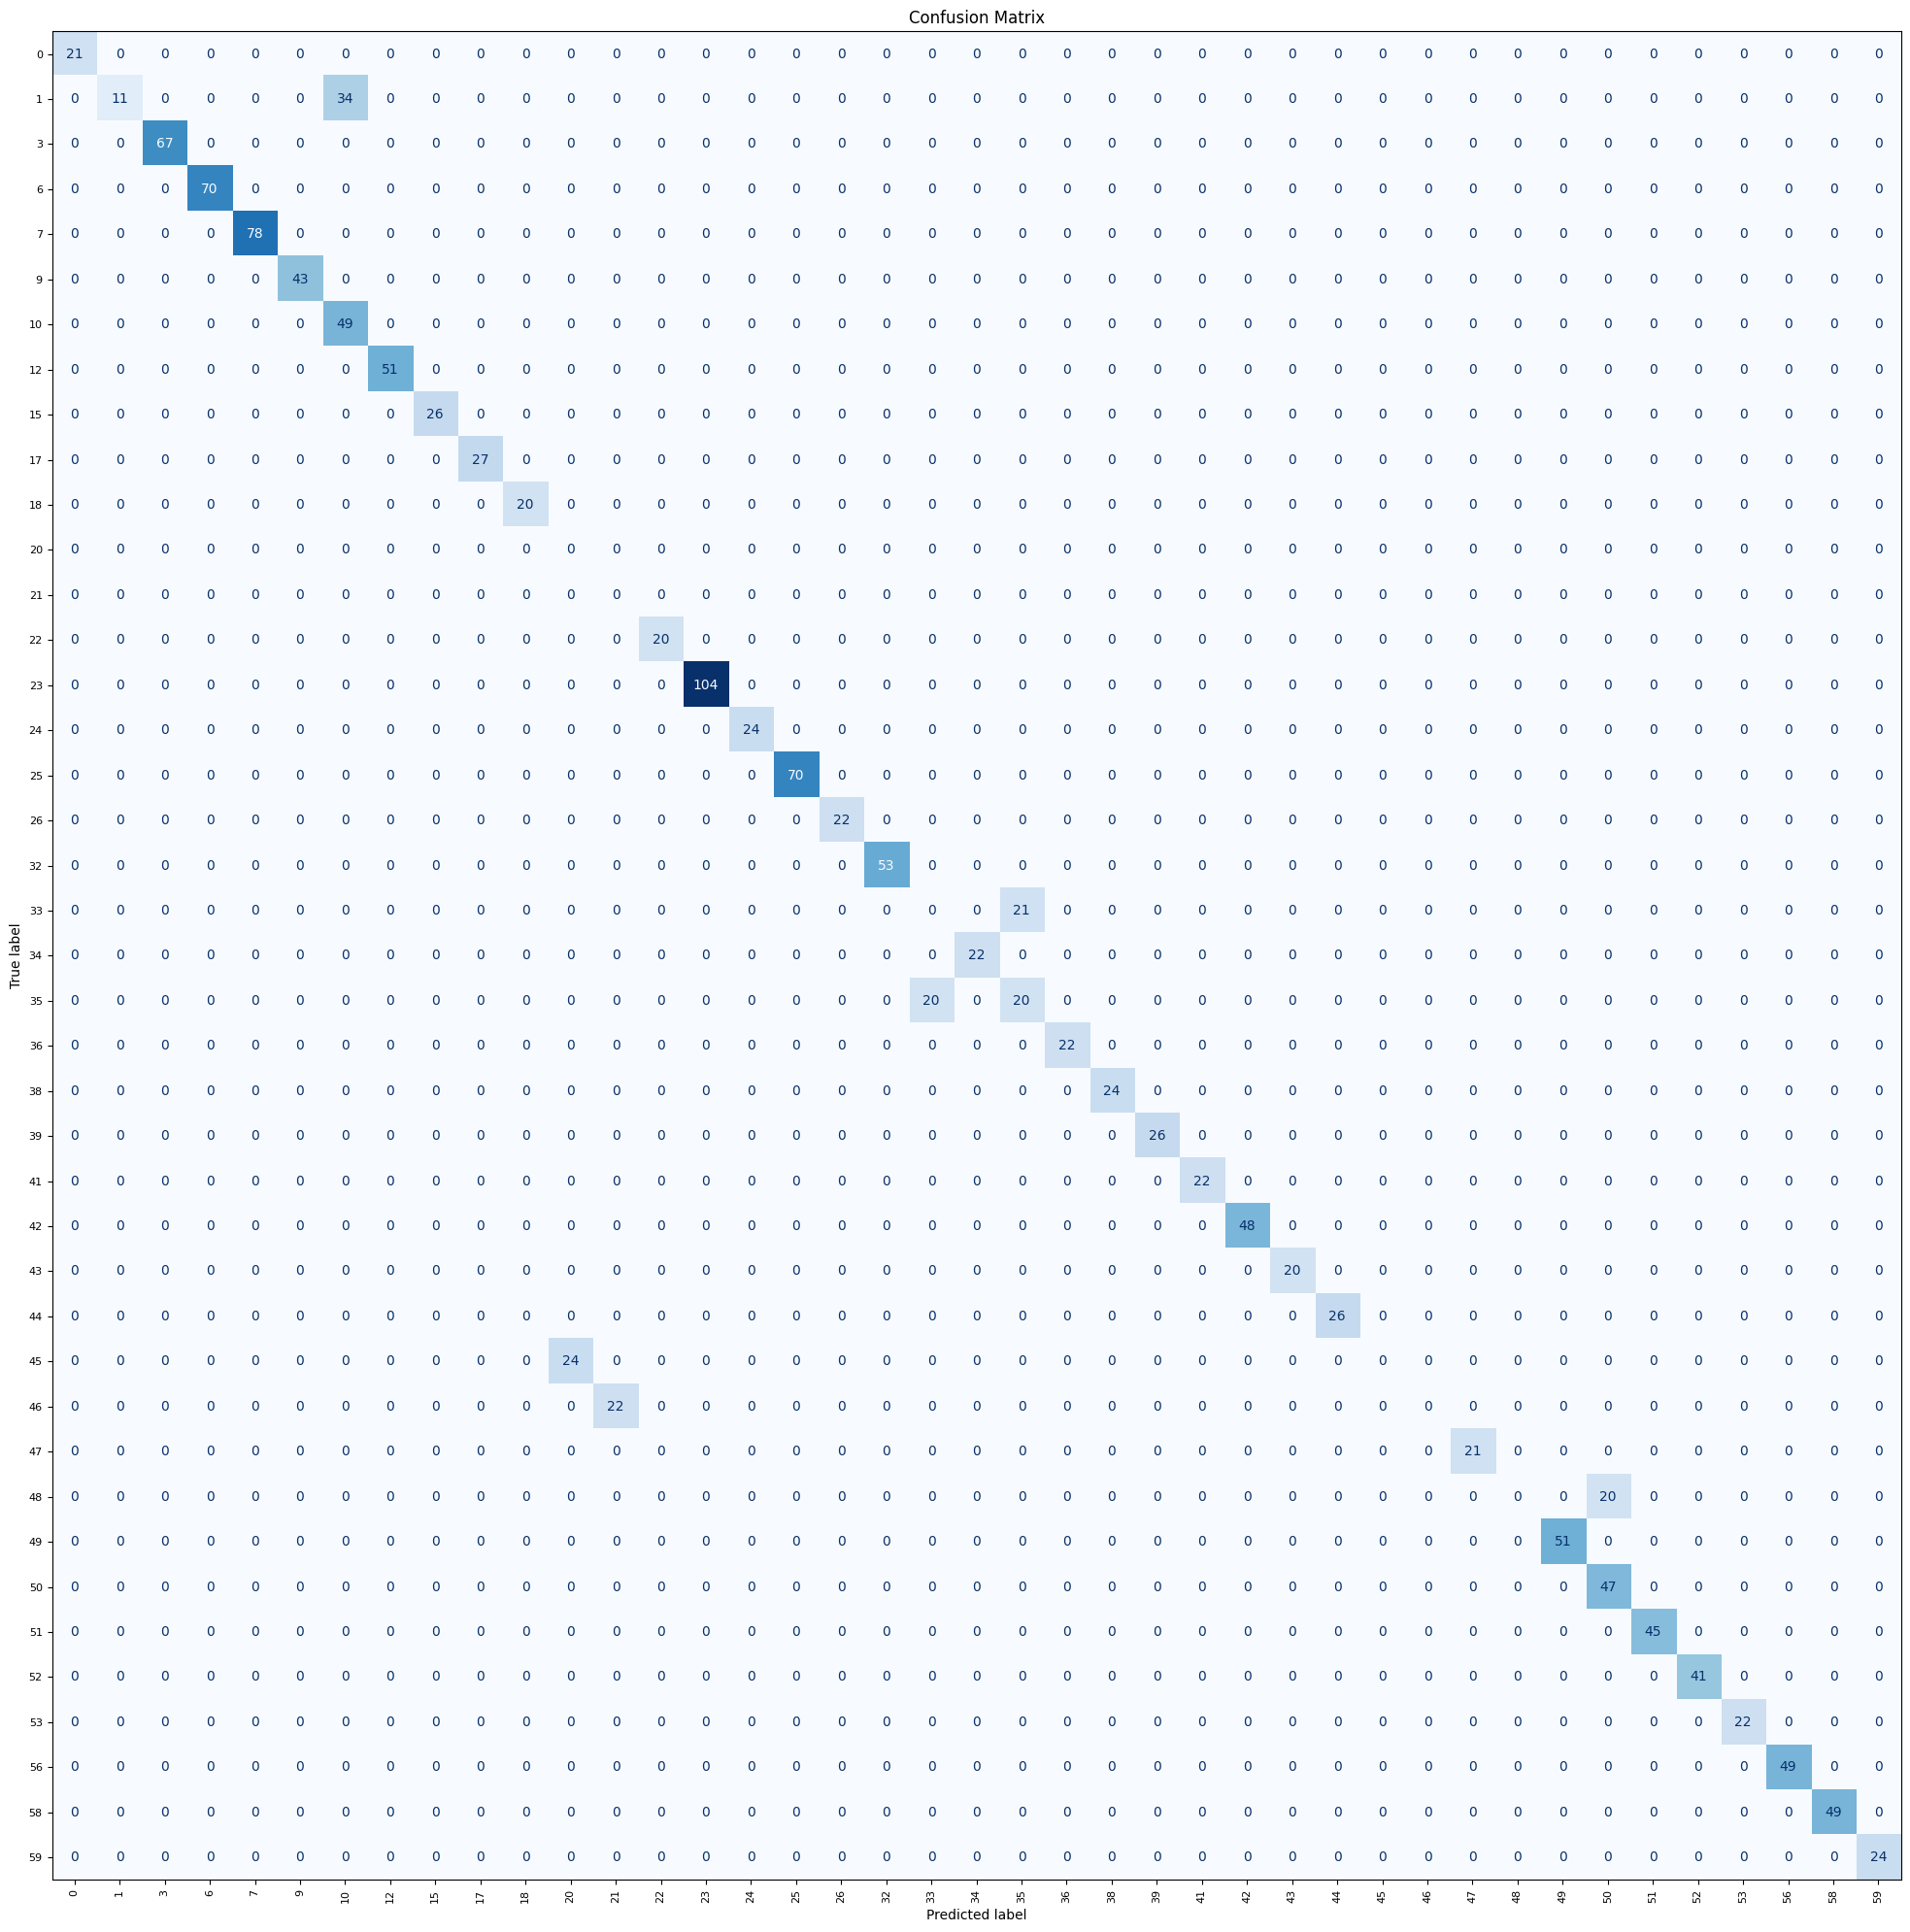

{'accuracy': 0.9044715447154471,
 'predicted_labels': array([ 0,  0,  0, ..., 59, 59, 59]),
 'true_labels': 86       0
 87       0
 88       0
 89       0
 90       0
         ..
 7875    59
 7876    59
 7877    59
 7878    59
 7879    59
 Name: genus_species_label, Length: 1476, dtype: int64}

In [44]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_genus_species_level_smote)

## Aplicando grid search en busca de los mejores híper parámetros con SMOTE

In [125]:
param_grid_for_SMOTE = {
    'n_neighbors': [3, 5, 7, ],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto','ball_tree', 'brute']
}

In [126]:
grid_search_for_SMOTE = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_for_SMOTE,
    cv=4,  # Validación cruzada
    scoring='accuracy',  # Métrica principal
    verbose=3,  # Mostrar progreso
    n_jobs=-1  # Usar todos los núcleos disponibles
)

grid_search_for_SMOTE.fit(x_train_smote, genus_species_smote)

# Resultados del mejor modelo
print("Best Parameters:", grid_search_for_SMOTE.best_params_)
print("Best Cross-Validated Score:", grid_search_for_SMOTE.best_score_)

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Best Parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Best Cross-Validated Score: 1.0


In [127]:
joblib.dump(grid_search_for_SMOTE, "grid_search_knn_with_smote.pkl")

['grid_search_knn_with_smote.pkl']

In [ ]:
grid_search_knn_with_smote = joblib.load('grid_search_knn_with_smote.pkl')
results = grid_search_knn_with_smote.cv_results_
results_df = pd.DataFrame(results)
results_df

In [25]:
knn_best_smote = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean', algorithm='auto')
knn_best_smote.fit(x_train_smote, genus_species_smote)

KNeighborsClassifier(metric='euclidean', n_neighbors=7)

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------
KNN Classifier Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      0.29      0.45        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       1.00      1.00      1.00        78
           9       1.00      1.00      1.00        43
          10       0.60      1.00      0.75        49
          12       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        26
          17       1.00      1.00      1.00        27
          18       1.00      1.00      1.00        20
          20       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.

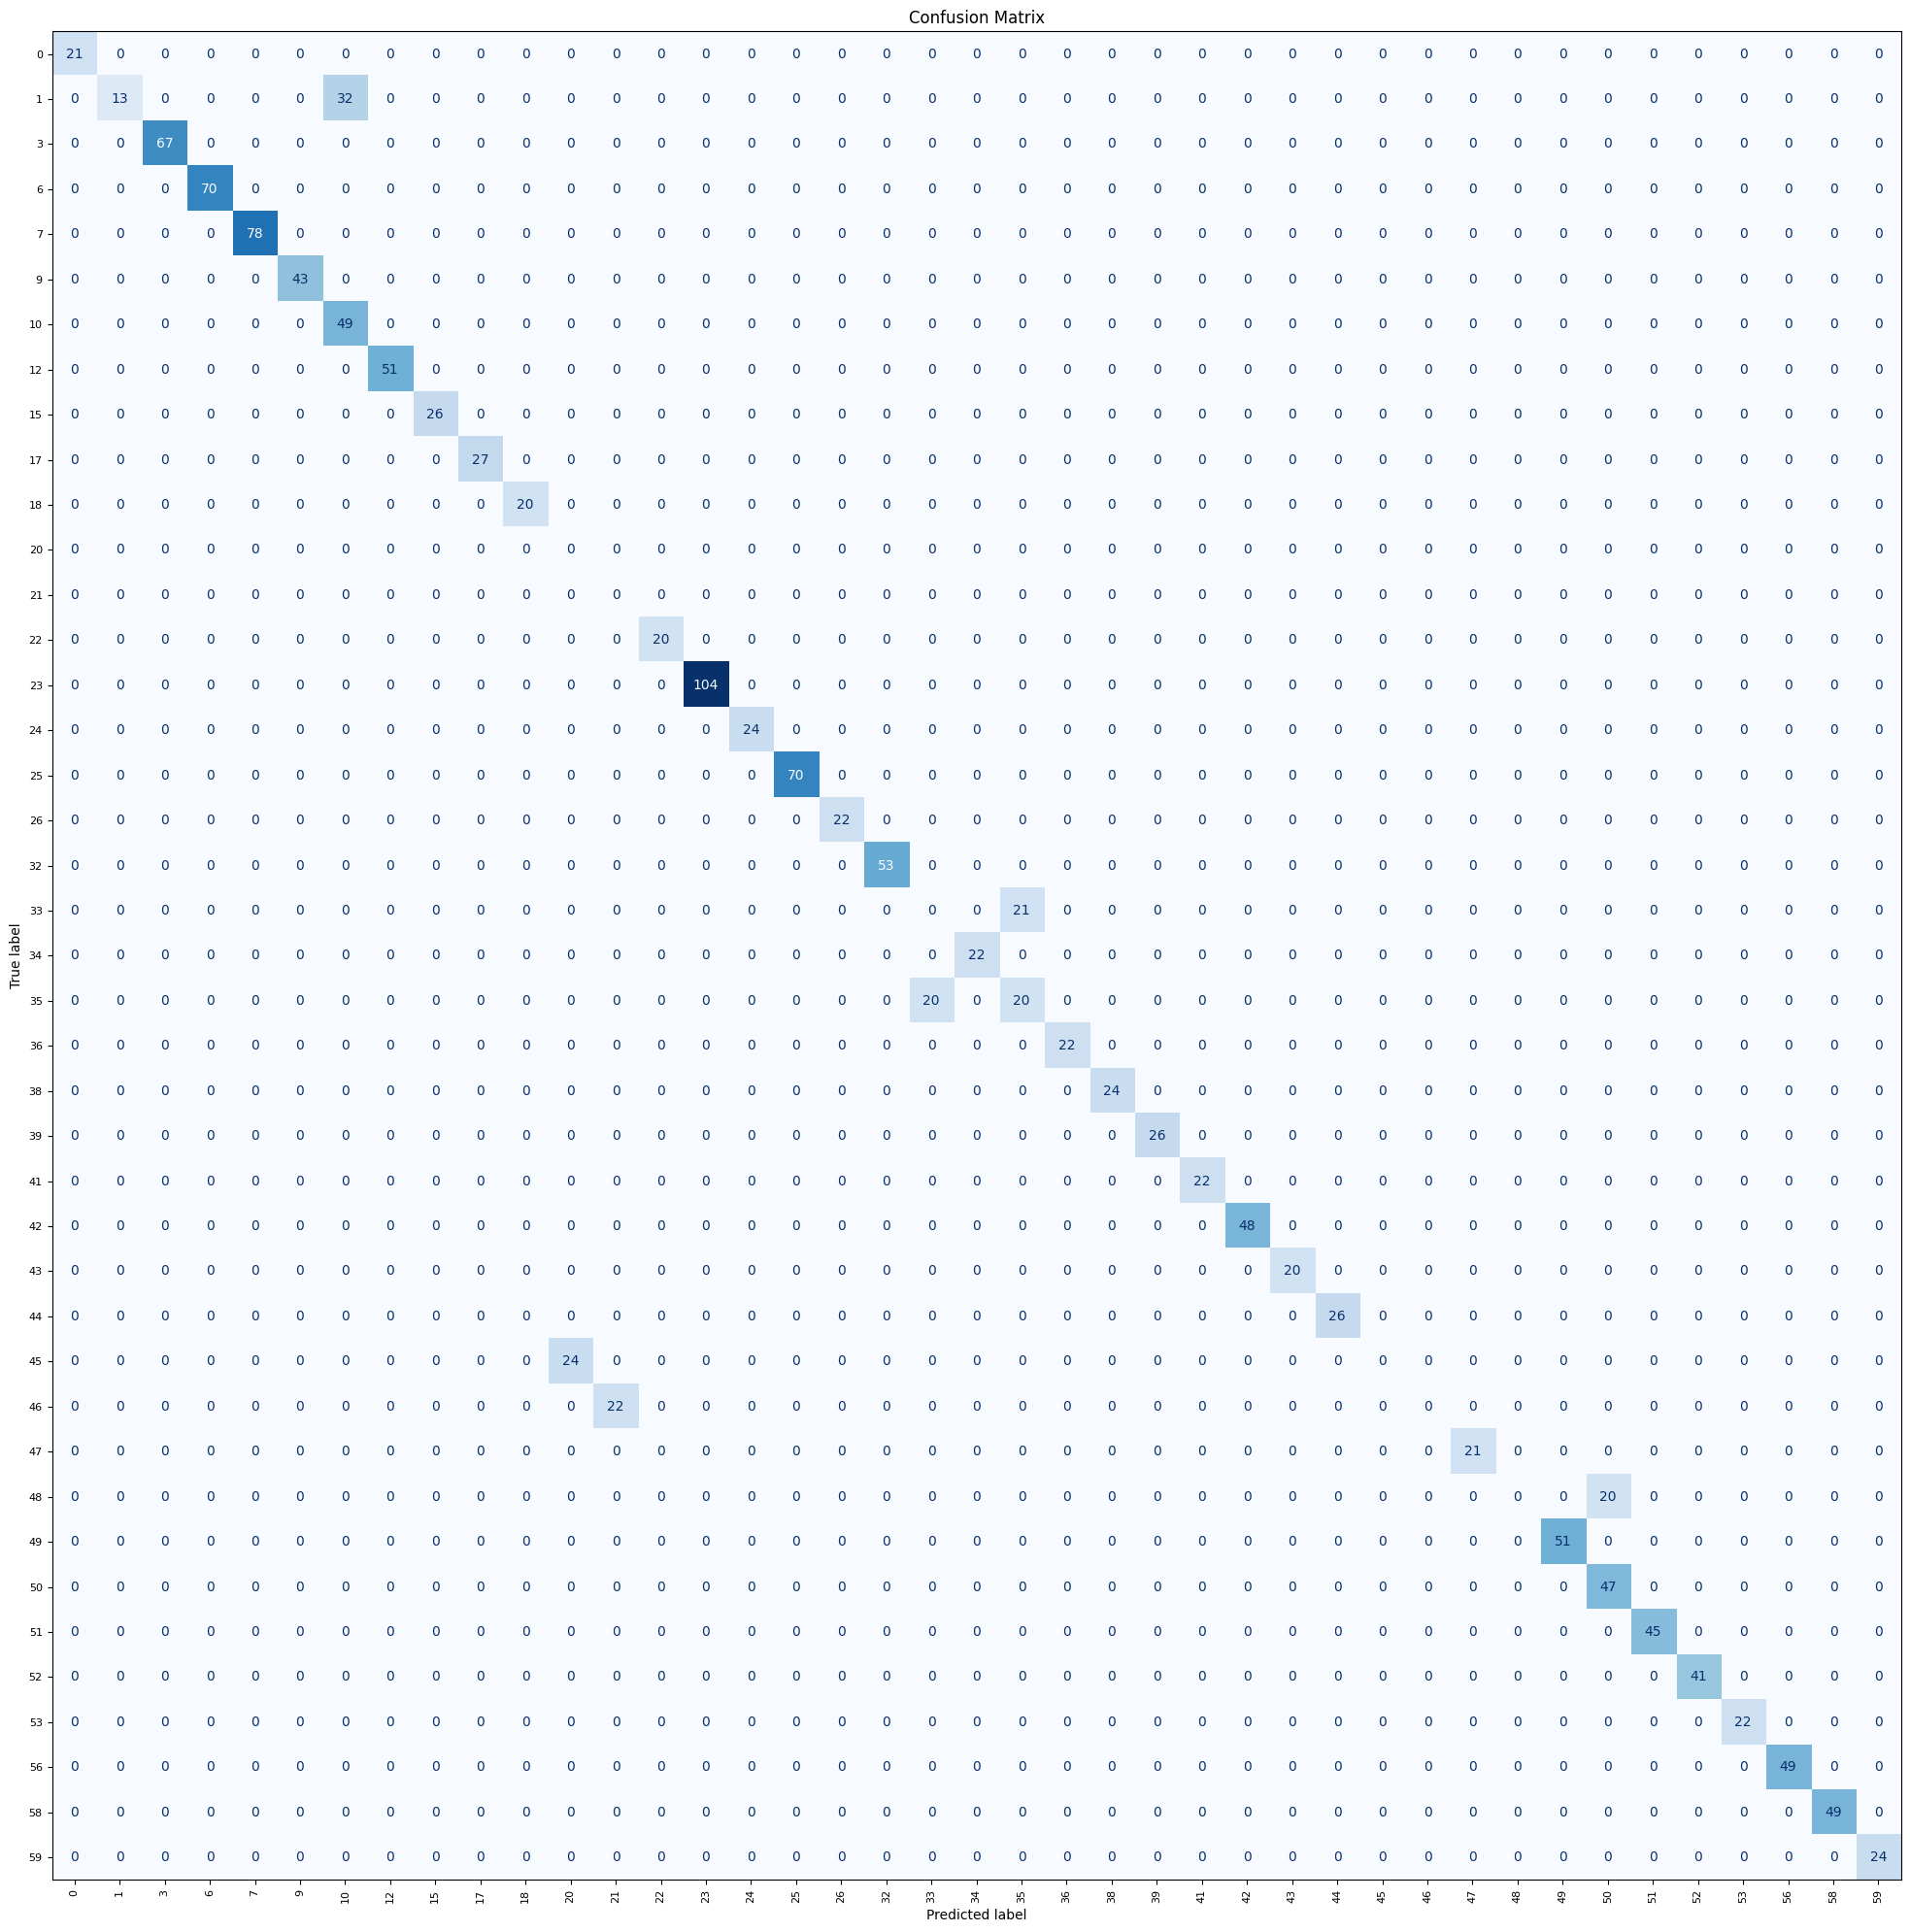

In [26]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON SMOTE -----------------------------------")
results = evaluate_knn_classifier(spectrum_test, genus_species_label_test, knn_best_smote)

In [28]:
#export knn best_smote
joblib.dump(knn_best_smote, "knn_best_genus_species.pkl")

['knn_best_genus_species.pkl']

In [ ]:
knn_best_smote = KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean', algorithm='auto')
knn_best_smote.fit(x_train_smote, genus_smote)

In [ ]:
pd.DataFrame(genus_smote).to_csv('genus_test_labels_smote.csv', index=False)

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO CON SMOTE -----------------------------------
KNN Classifier Accuracy: 0.96

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       497
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00       104
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        70
           5       1.00      1.00      1.00        22
           6       1.00      1.00      1.00       158
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        48
          11       1.00      0.50      0.67        92
          12       1.00      1.00      1.00        21
          13       0.00      0.00      0.00        20
          14       0.83      1.00      0.91        98
          15       1.00      1.

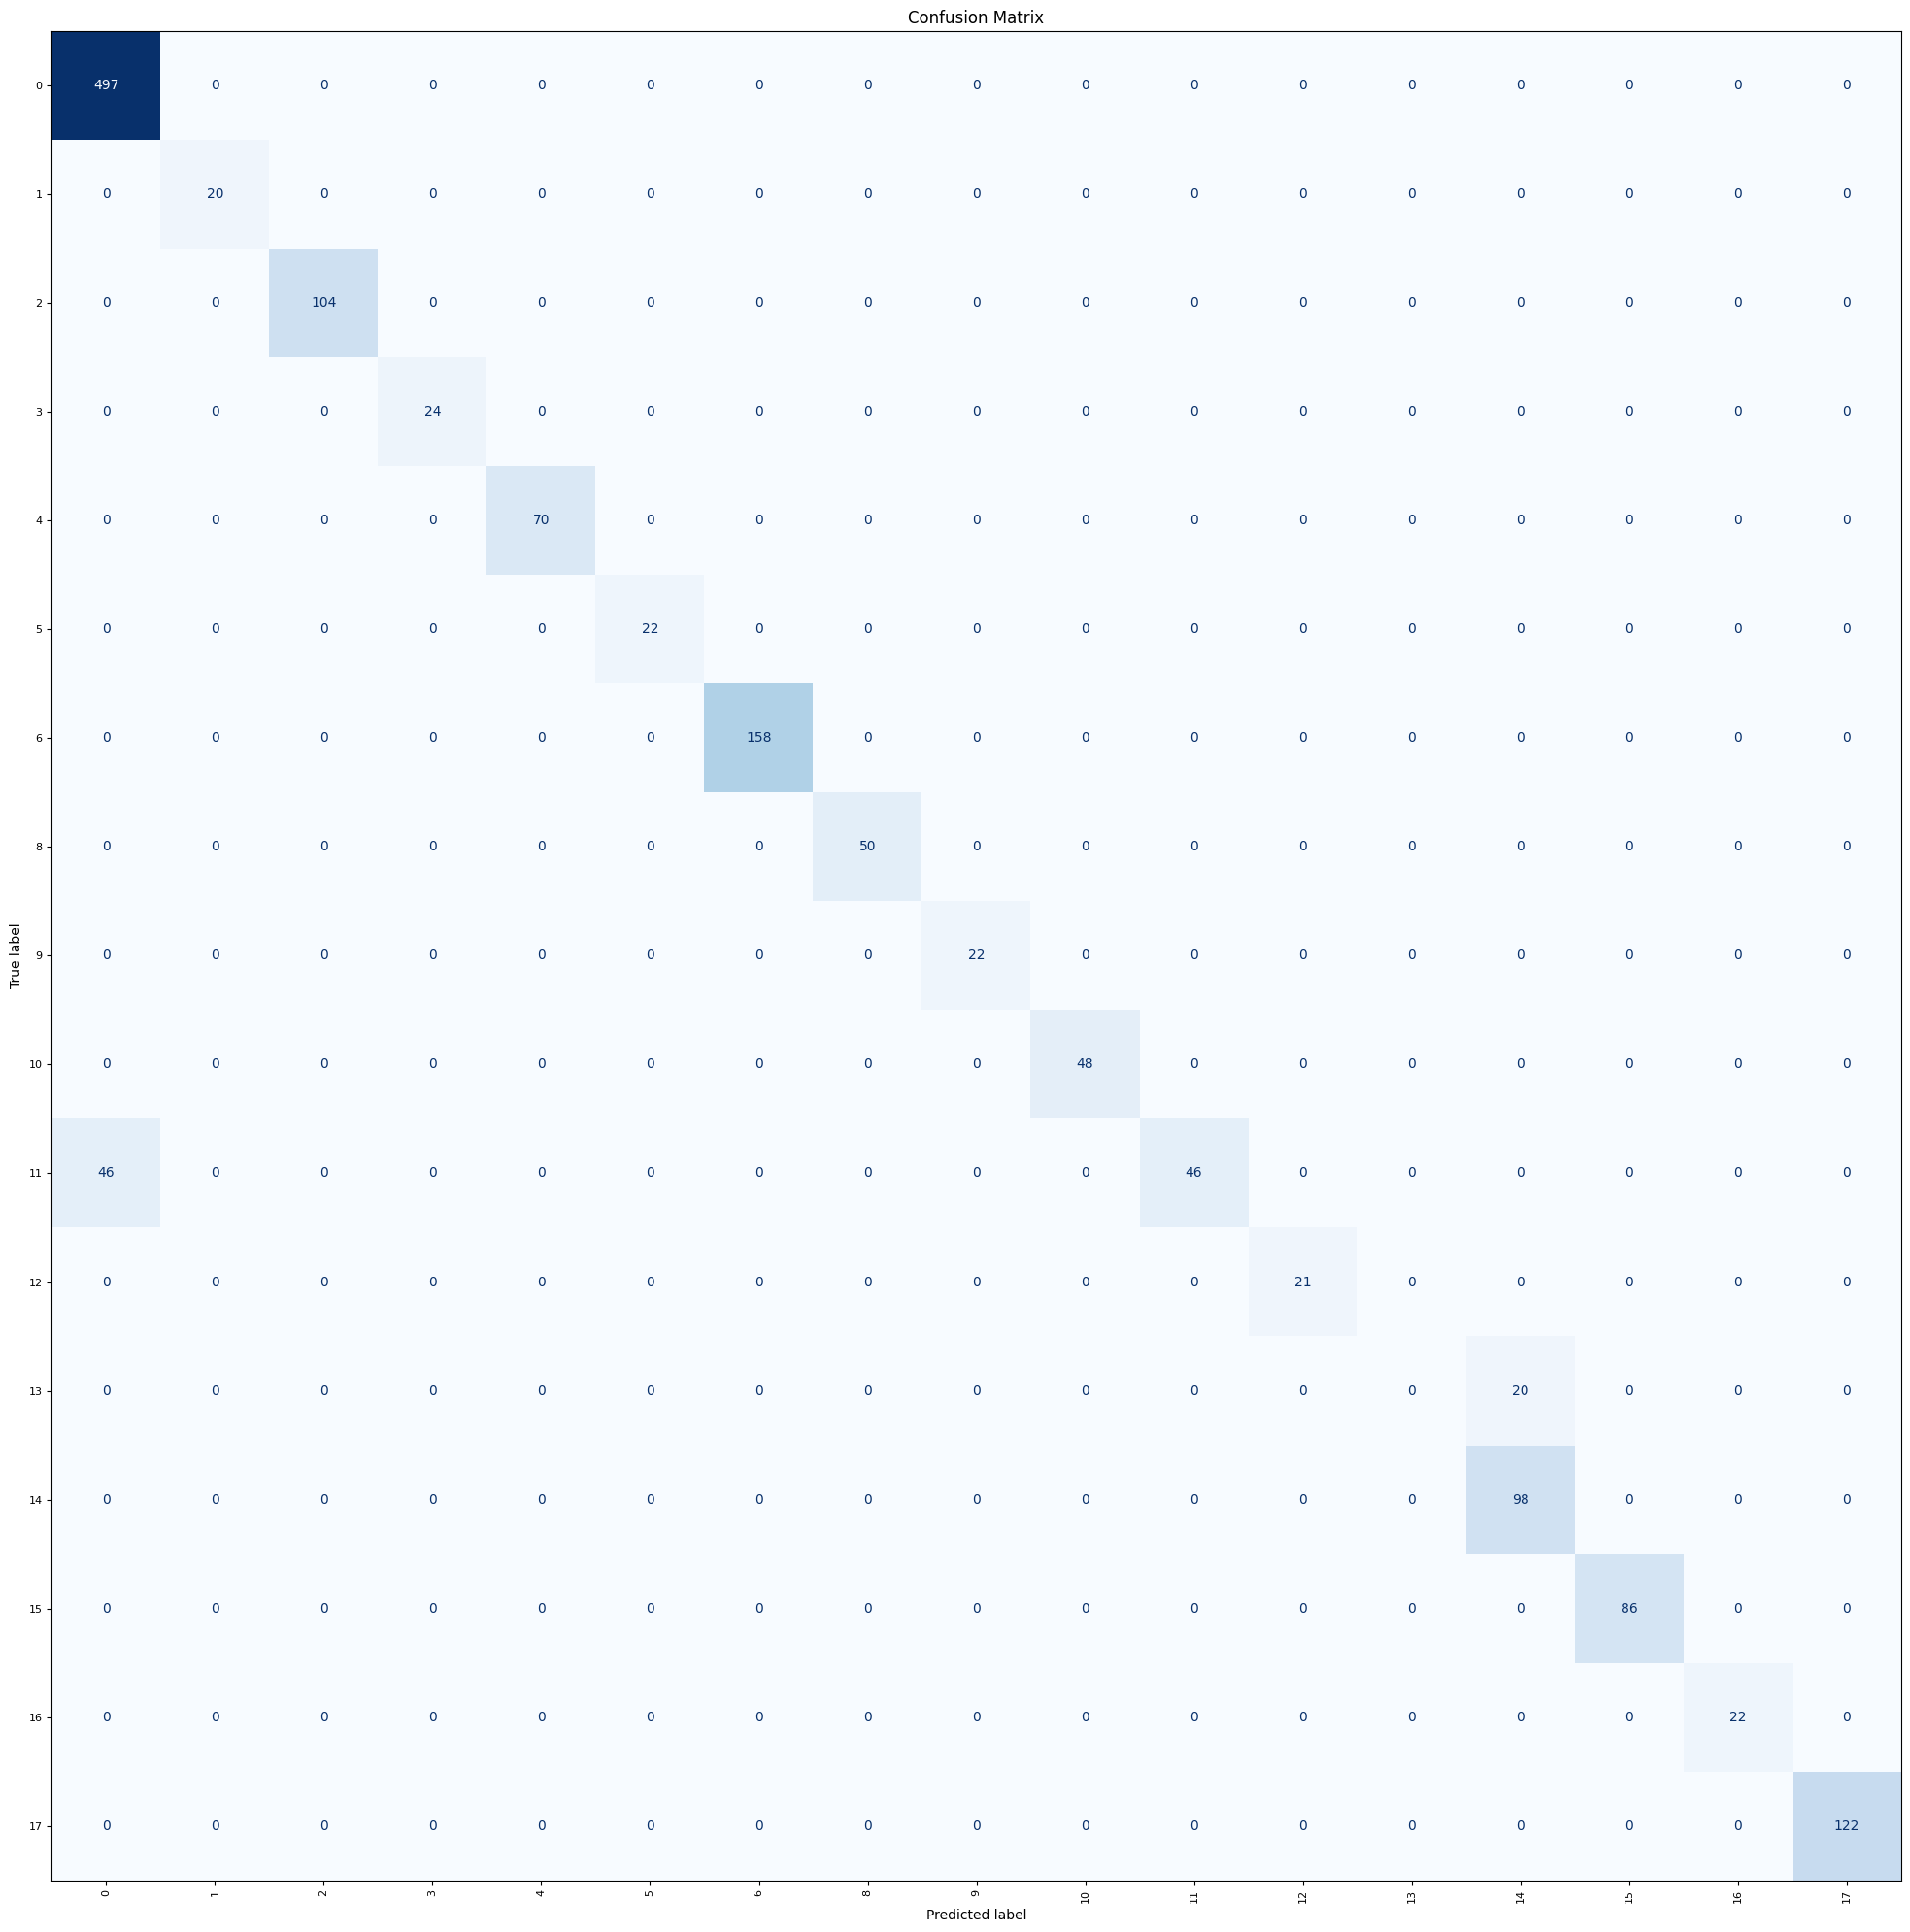

In [22]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO CON SMOTE -----------------------------------")
results = evaluate_knn_classifier(spectrum_test, genus_label_test, knn_best_smote)

In [36]:
# Convertir Series a arrays de NumPy
true_labels_column = results['true_labels'].values.reshape(-1, 1)
predicted_labels_column = results['predicted_labels'].reshape(-1, 1)

# Concatenar los datos del test con las etiquetas reales y predichas
combined_data = np.hstack((spectrum_test, true_labels_column, predicted_labels_column))

# Convertir a DataFrame para un análisis más fácil
feature_columns = [f'feature_{i}' for i in range(spectrum_test.shape[1])]
df = pd.DataFrame(combined_data, columns=feature_columns + ['real_label', 'predicted_label'])

In [37]:

class_eleven_bad_classified = df[(df['real_label'] == 11) & (df['predicted_label'] == 0)]
class_eleven_well_classified = df[(df['real_label'] == 11) & (df['predicted_label'] == 11)]
class_zero_well_classified = df[(df['real_label'] == 0) & (df['predicted_label'] == 0)]


In [25]:
feature_columns = [f'feature_{i}' for i in range(3000)]
wrong_spectra_data_11 = class_eleven_bad_classified[feature_columns]
correct_spectra_data_11 = class_eleven_well_classified[feature_columns]
correct_spectra_data_0 = class_zero_well_classified[feature_columns]

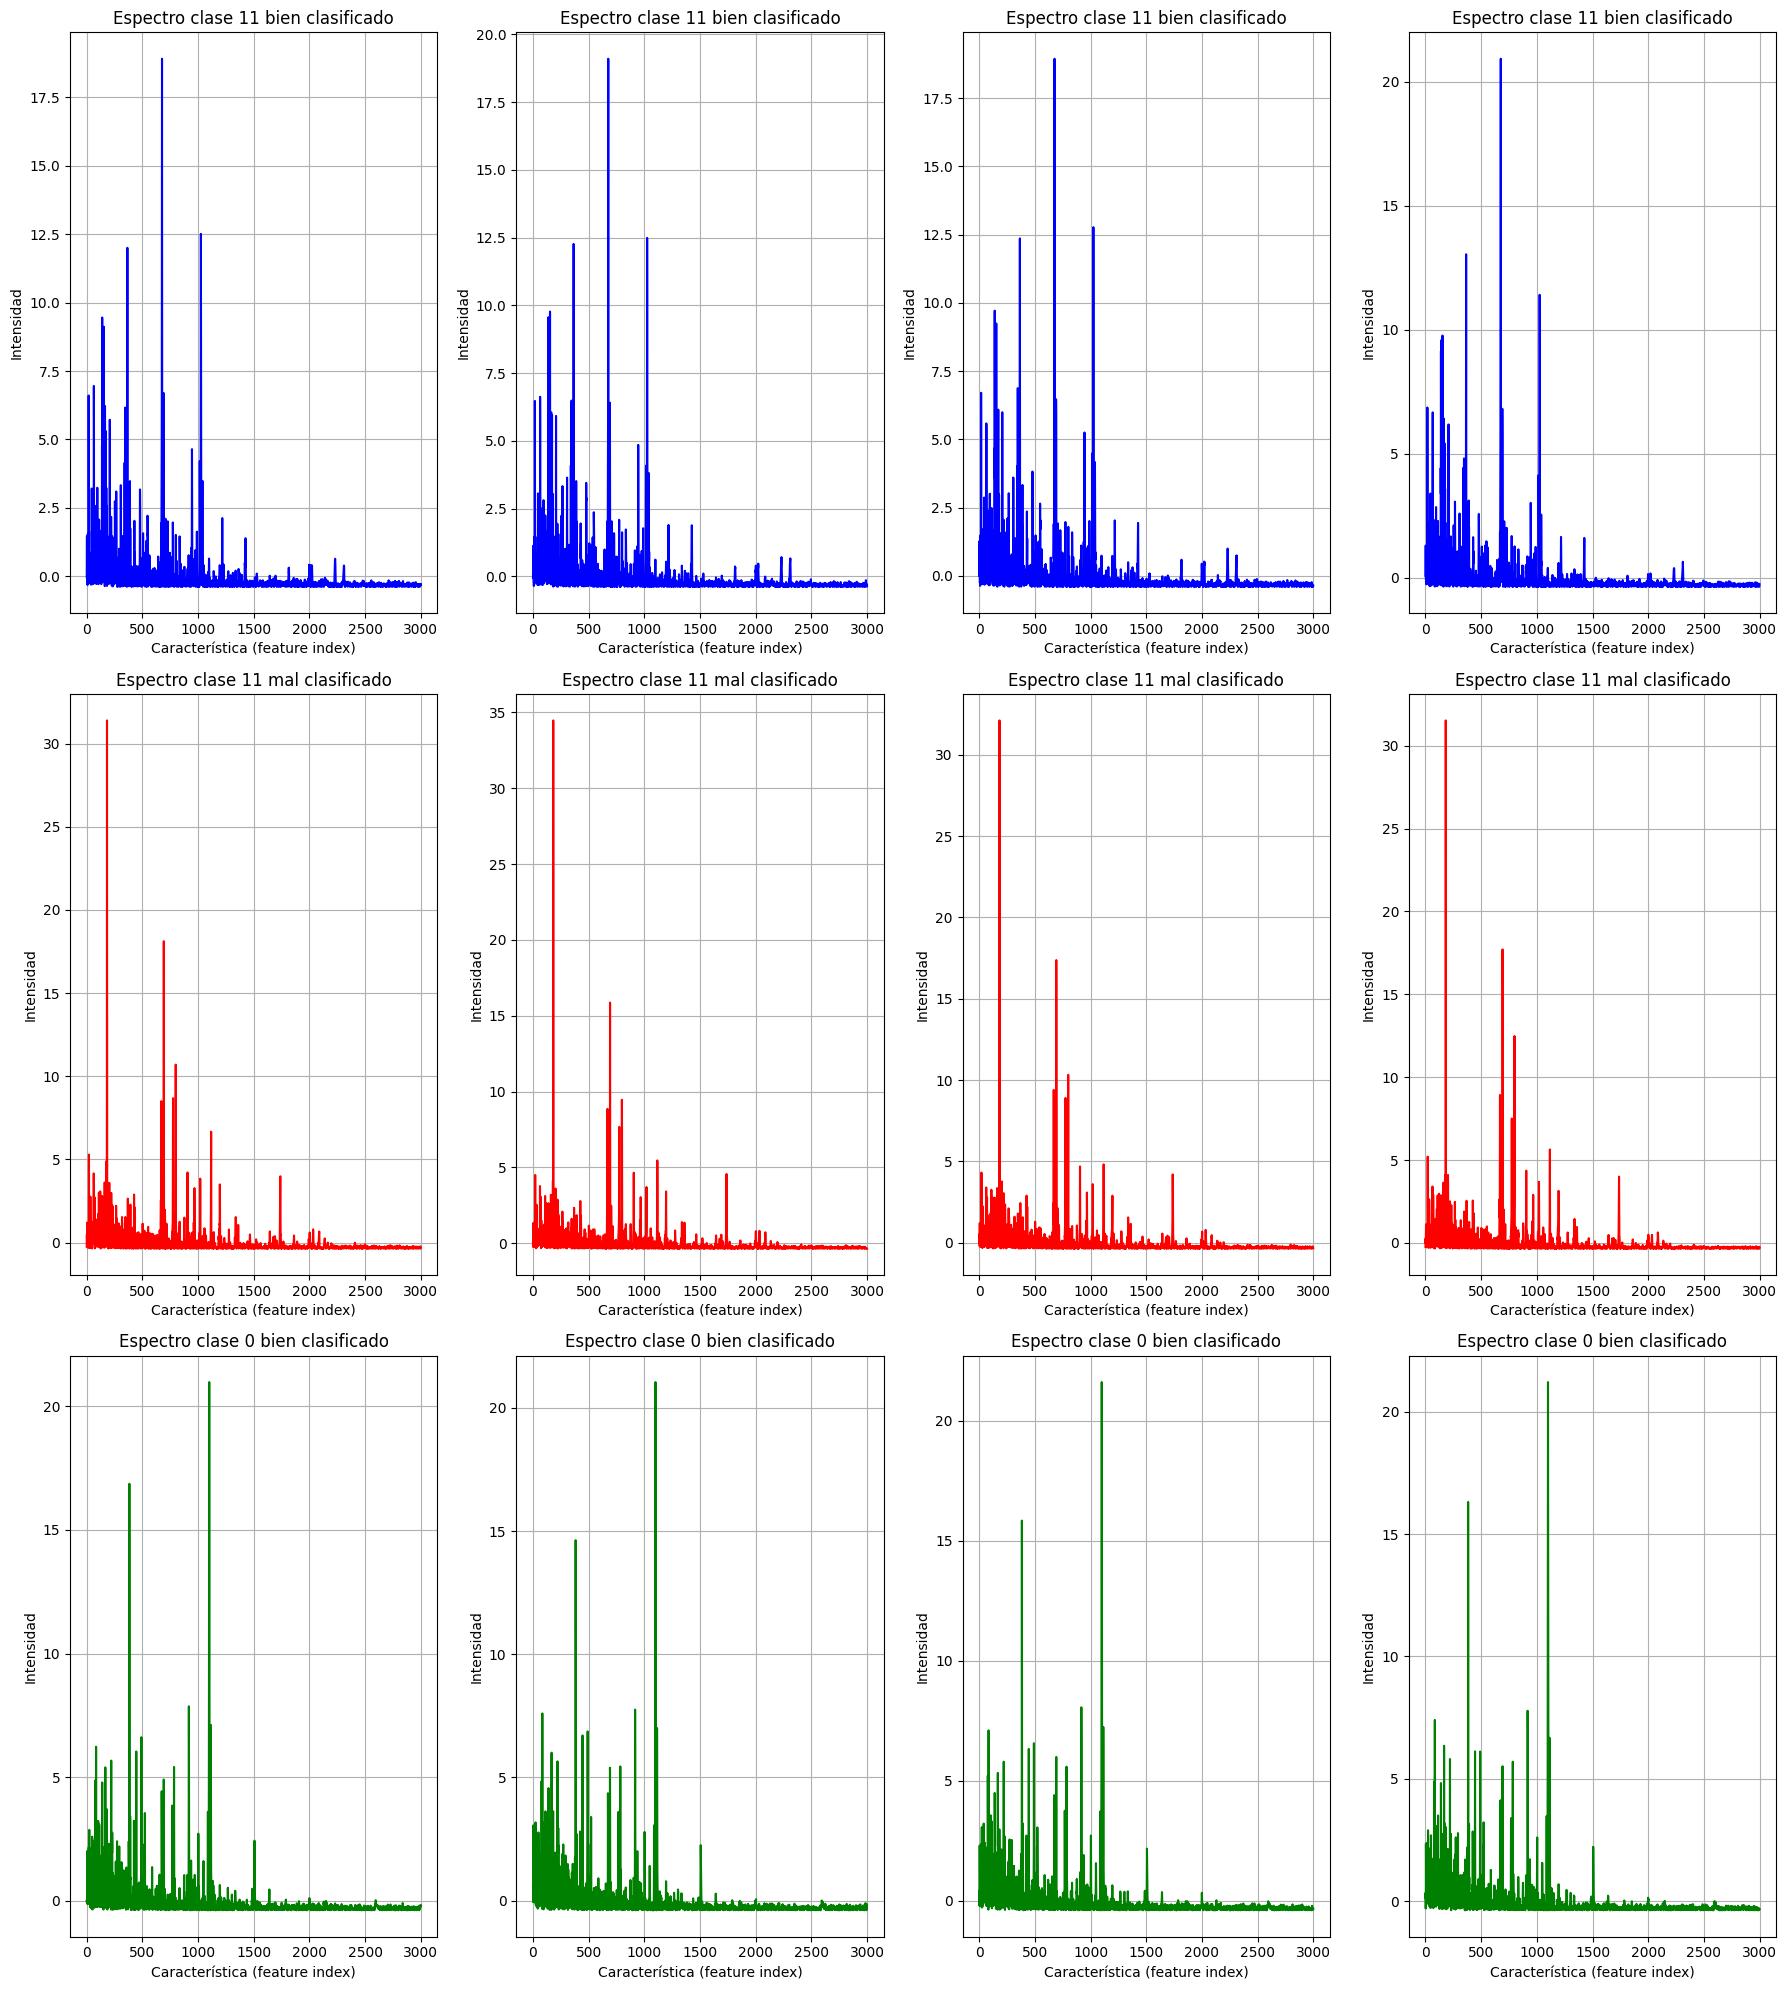

In [26]:


# Crear la figura y los ejes para 3 filas y 3 columnas
fig, axes = plt.subplots(3, 4, figsize=(18, 20))  # 5 filas y 3 columnas

# Iterar para graficar cada espectro en su respectiva columna
for i in range(4):
    # Espectro clase 11 bien clasificado (Columna 0)
    axes[0, i].plot(range(3000), correct_spectra_data_11.iloc[i], color='blue')
    axes[0, i].set_title(f'Espectro clase 11 bien clasificado', fontsize=12)
    axes[0, i].set_xlabel('Característica (feature index)', fontsize=10)
    axes[0, i].set_ylabel('Intensidad', fontsize=10)
    axes[0, i].grid(True)

    # Espectro clase 11 mal clasificado (Columna 1)
    axes[1,i].plot(range(3000), wrong_spectra_data_11.iloc[i], color='red')
    axes[1,i].set_title(f'Espectro clase 11 mal clasificado', fontsize=12)
    axes[1,i].set_xlabel('Característica (feature index)', fontsize=10)
    axes[1,i].set_ylabel('Intensidad', fontsize=10)
    axes[1,i].grid(True)

    # Espectro clase 0 bien clasificado (Columna 2)
    axes[2,i].plot(range(3000), correct_spectra_data_0.iloc[i], color='green')
    axes[2,i].set_title(f'Espectro clase 0 bien clasificado', fontsize=12)
    axes[2,i].set_xlabel('Característica (feature index)', fontsize=10)
    axes[2,i].set_ylabel('Intensidad', fontsize=10)
    axes[2,i].grid(True)

# Ajustar el espacio entre gráficos
plt.tight_layout()
plt.show()



In [27]:
class_thirteen_bad_classified = df[(df['real_label'] == 13) & (df['predicted_label'] != 13)]
class_fourteen_well_classified = df[(df['real_label'] == 14) & (df['predicted_label'] == 14)]

In [28]:
wrong_spectra_data_11 = class_thirteen_bad_classified[feature_columns]
correct_spectra_data_14 = class_fourteen_well_classified[feature_columns]

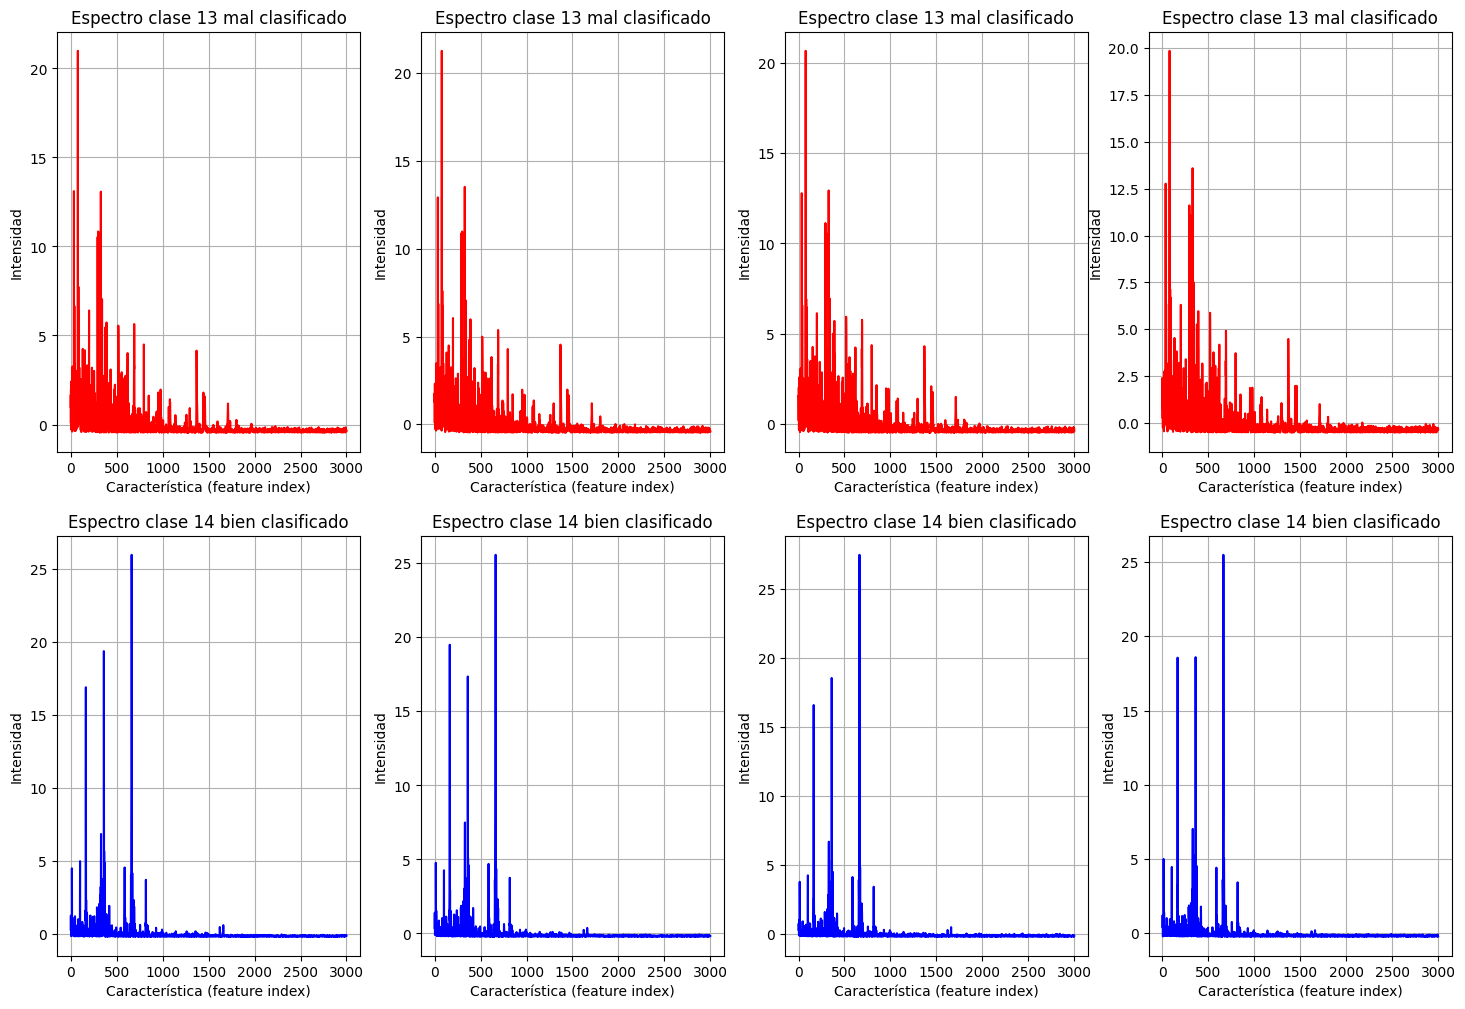

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(18, 12))

for i in range(4):
    axes[0, i].plot(range(3000), wrong_spectra_data_11.iloc[i], color='red')
    axes[0, i].set_title(f'Espectro clase 13 mal clasificado', fontsize=12)
    axes[0,i].set_xlabel('Característica (feature index)', fontsize=10)
    axes[0,i].set_ylabel('Intensidad', fontsize=10)
    axes[0,i].grid(True)
    axes[1, i].plot(range(3000), correct_spectra_data_14.iloc[i], color='blue')
    axes[1, i].set_title(f'Espectro clase 14 bien clasificado', fontsize=12)
    axes[1,i].set_xlabel('Característica (feature index)', fontsize=10)
    axes[1,i].set_ylabel('Intensidad', fontsize=10)
    axes[1,i].grid(True)

In [46]:
#Agrupa genus_smote y cuenta cuantas veces aparece cada uno
genus_smote_count = Counter(genus_smote)
#Imprime el número de veces que aparece cada genus en formato bonito
print(genus_smote_count)


Counter({np.int64(0): 8228, np.int64(6): 3740, np.int64(17): 2244, np.int64(11): 1496, np.int64(8): 748, np.int64(9): 748, np.int64(14): 748, np.int64(15): 748, np.int64(1): 374, np.int64(2): 374, np.int64(3): 374, np.int64(4): 374, np.int64(5): 374, np.int64(7): 374, np.int64(10): 374, np.int64(12): 374, np.int64(13): 374, np.int64(16): 374})


In [31]:
! pip install umap-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\aleta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\aleta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\aleta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


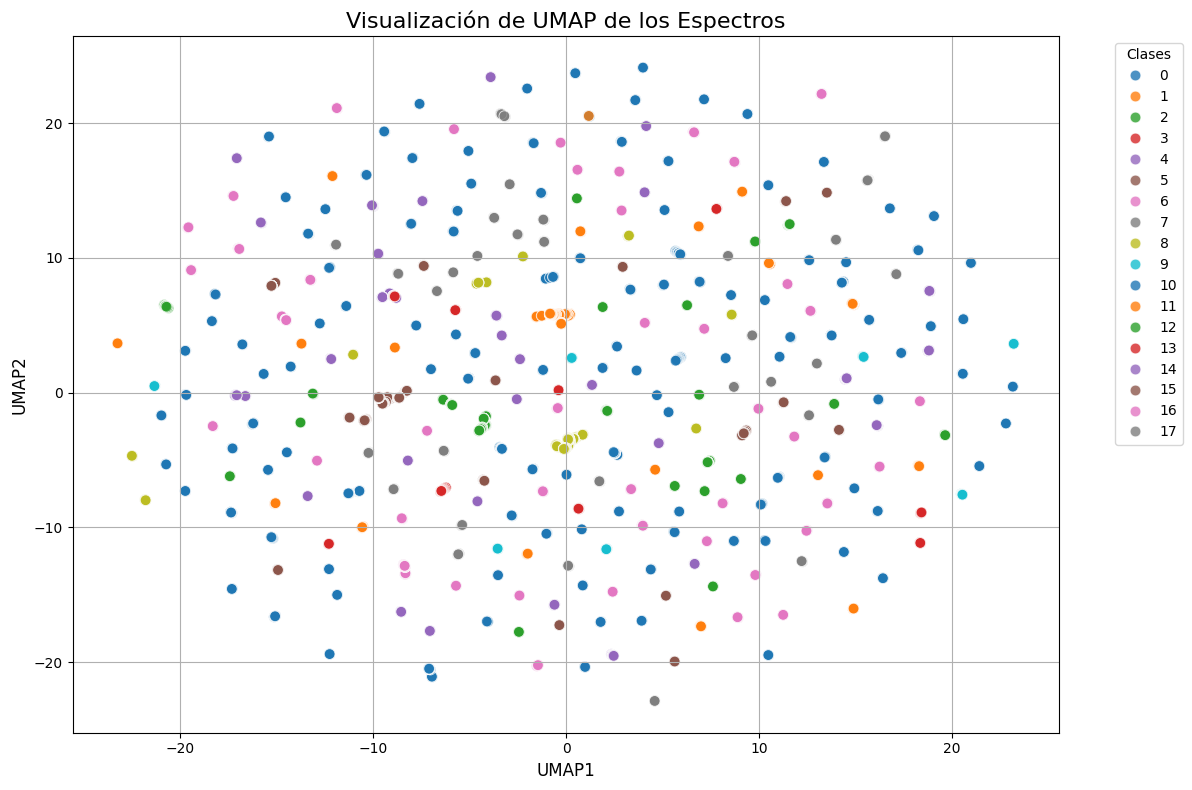

In [42]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supongamos que 'spectrum_test' es tu conjunto de datos preprocesado
# Y 'y_test' son las etiquetas reales de las muestras

# Aplicar UMAP para reducir a 2 dimensiones
umap_reducer = umap.UMAP(n_neighbors=18, min_dist=0.1, random_state=42)
embedding_umap = umap_reducer.fit_transform(spectrum_completo)

# Convertir a DataFrame para facilitar la visualización
umap_df = pd.DataFrame(embedding_umap, columns=['UMAP1', 'UMAP2'])
umap_df['label'] = genus_label_completo

# Graficar
plt.figure(figsize=(12, 8))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='label', palette='tab10', data=umap_df, s=60, alpha=0.8)

plt.title('Visualización de UMAP de los Espectros', fontsize=16)
plt.xlabel('UMAP1', fontsize=12)
plt.ylabel('UMAP2', fontsize=12)
plt.legend(title='Clases', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\aleta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


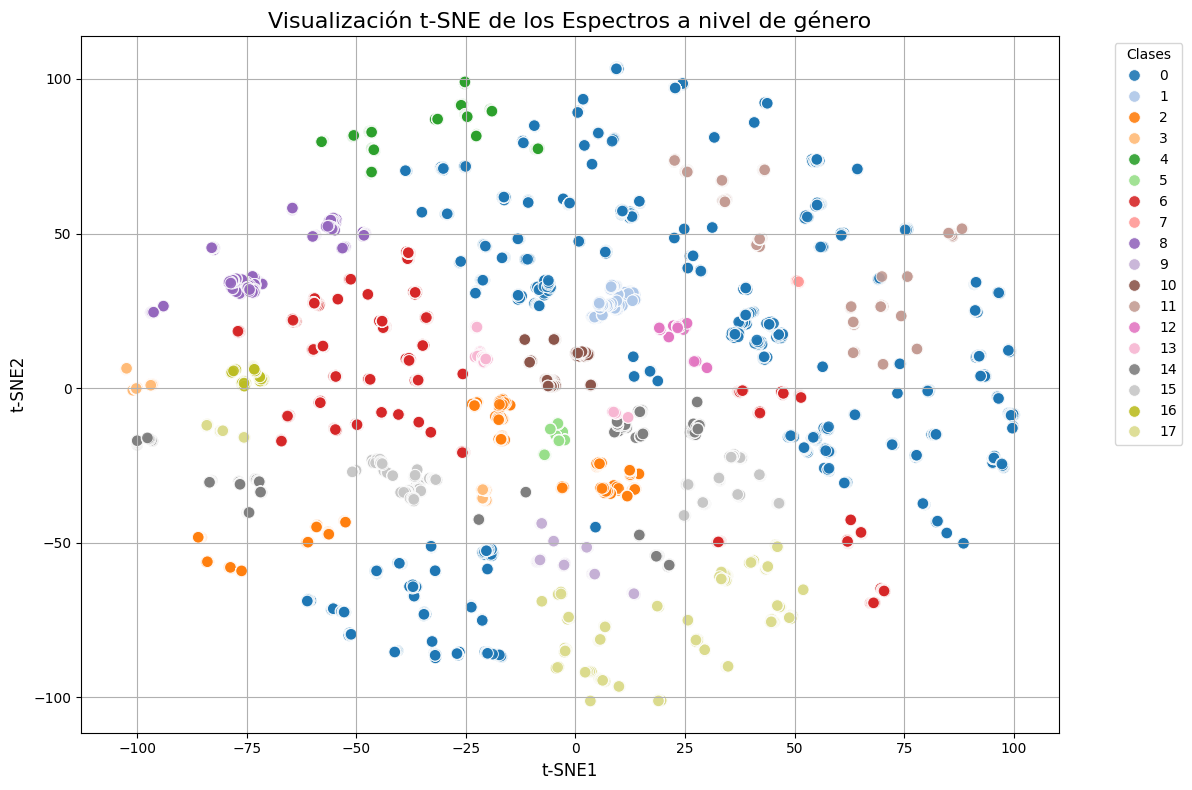

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Aplicar t-SNE para reducir a 2 dimensiones
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
embedding_tsne = tsne.fit_transform(spectrum_completo)

# Convertir a DataFrame para facilitar la visualización
tsne_df = pd.DataFrame(embedding_tsne, columns=['t-SNE1', 't-SNE2'])
tsne_df['label'] = genus_label_completo

# Graficar con una paleta de colores más diferenciada
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='t-SNE1', 
    y='t-SNE2', 
    hue='label', 
    palette='tab20',  # Cambiar la paleta de colores aquí
    data=tsne_df, 
    s=70, 
    alpha=0.9
)

# Personalización del gráfico
plt.title('Visualización t-SNE de los Espectros a nivel de género', fontsize=16)
plt.xlabel('t-SNE1', fontsize=12)
plt.ylabel('t-SNE2', fontsize=12)
plt.legend(title='Clases', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


# Random Forest

## Random forest con parámetros aleatorios

In [35]:
type(x_train_smote[0][0])

numpy.float64

In [28]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(x_train_smote, genus_species_smote)

NameError: name 'x_train_smote' is not defined

---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON RANDOM FOREST -----------------------------------
KNN Classifier Accuracy: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       0.68      0.51      0.58        45
           3       1.00      1.00      1.00        67
           6       1.00      1.00      1.00        70
           7       0.99      1.00      0.99        78
           9       0.80      1.00      0.89        43
          10       0.67      0.90      0.77        49
          12       0.61      1.00      0.76        51
          15       1.00      1.00      1.00        26
          17       1.00      0.04      0.07        27
          18       1.00      0.90      0.95        20
          21       0.00      0.00      0.00         0
          22       1.00      1.00      1.00        20
          23       1.00      1.00      1.00       104
          24 

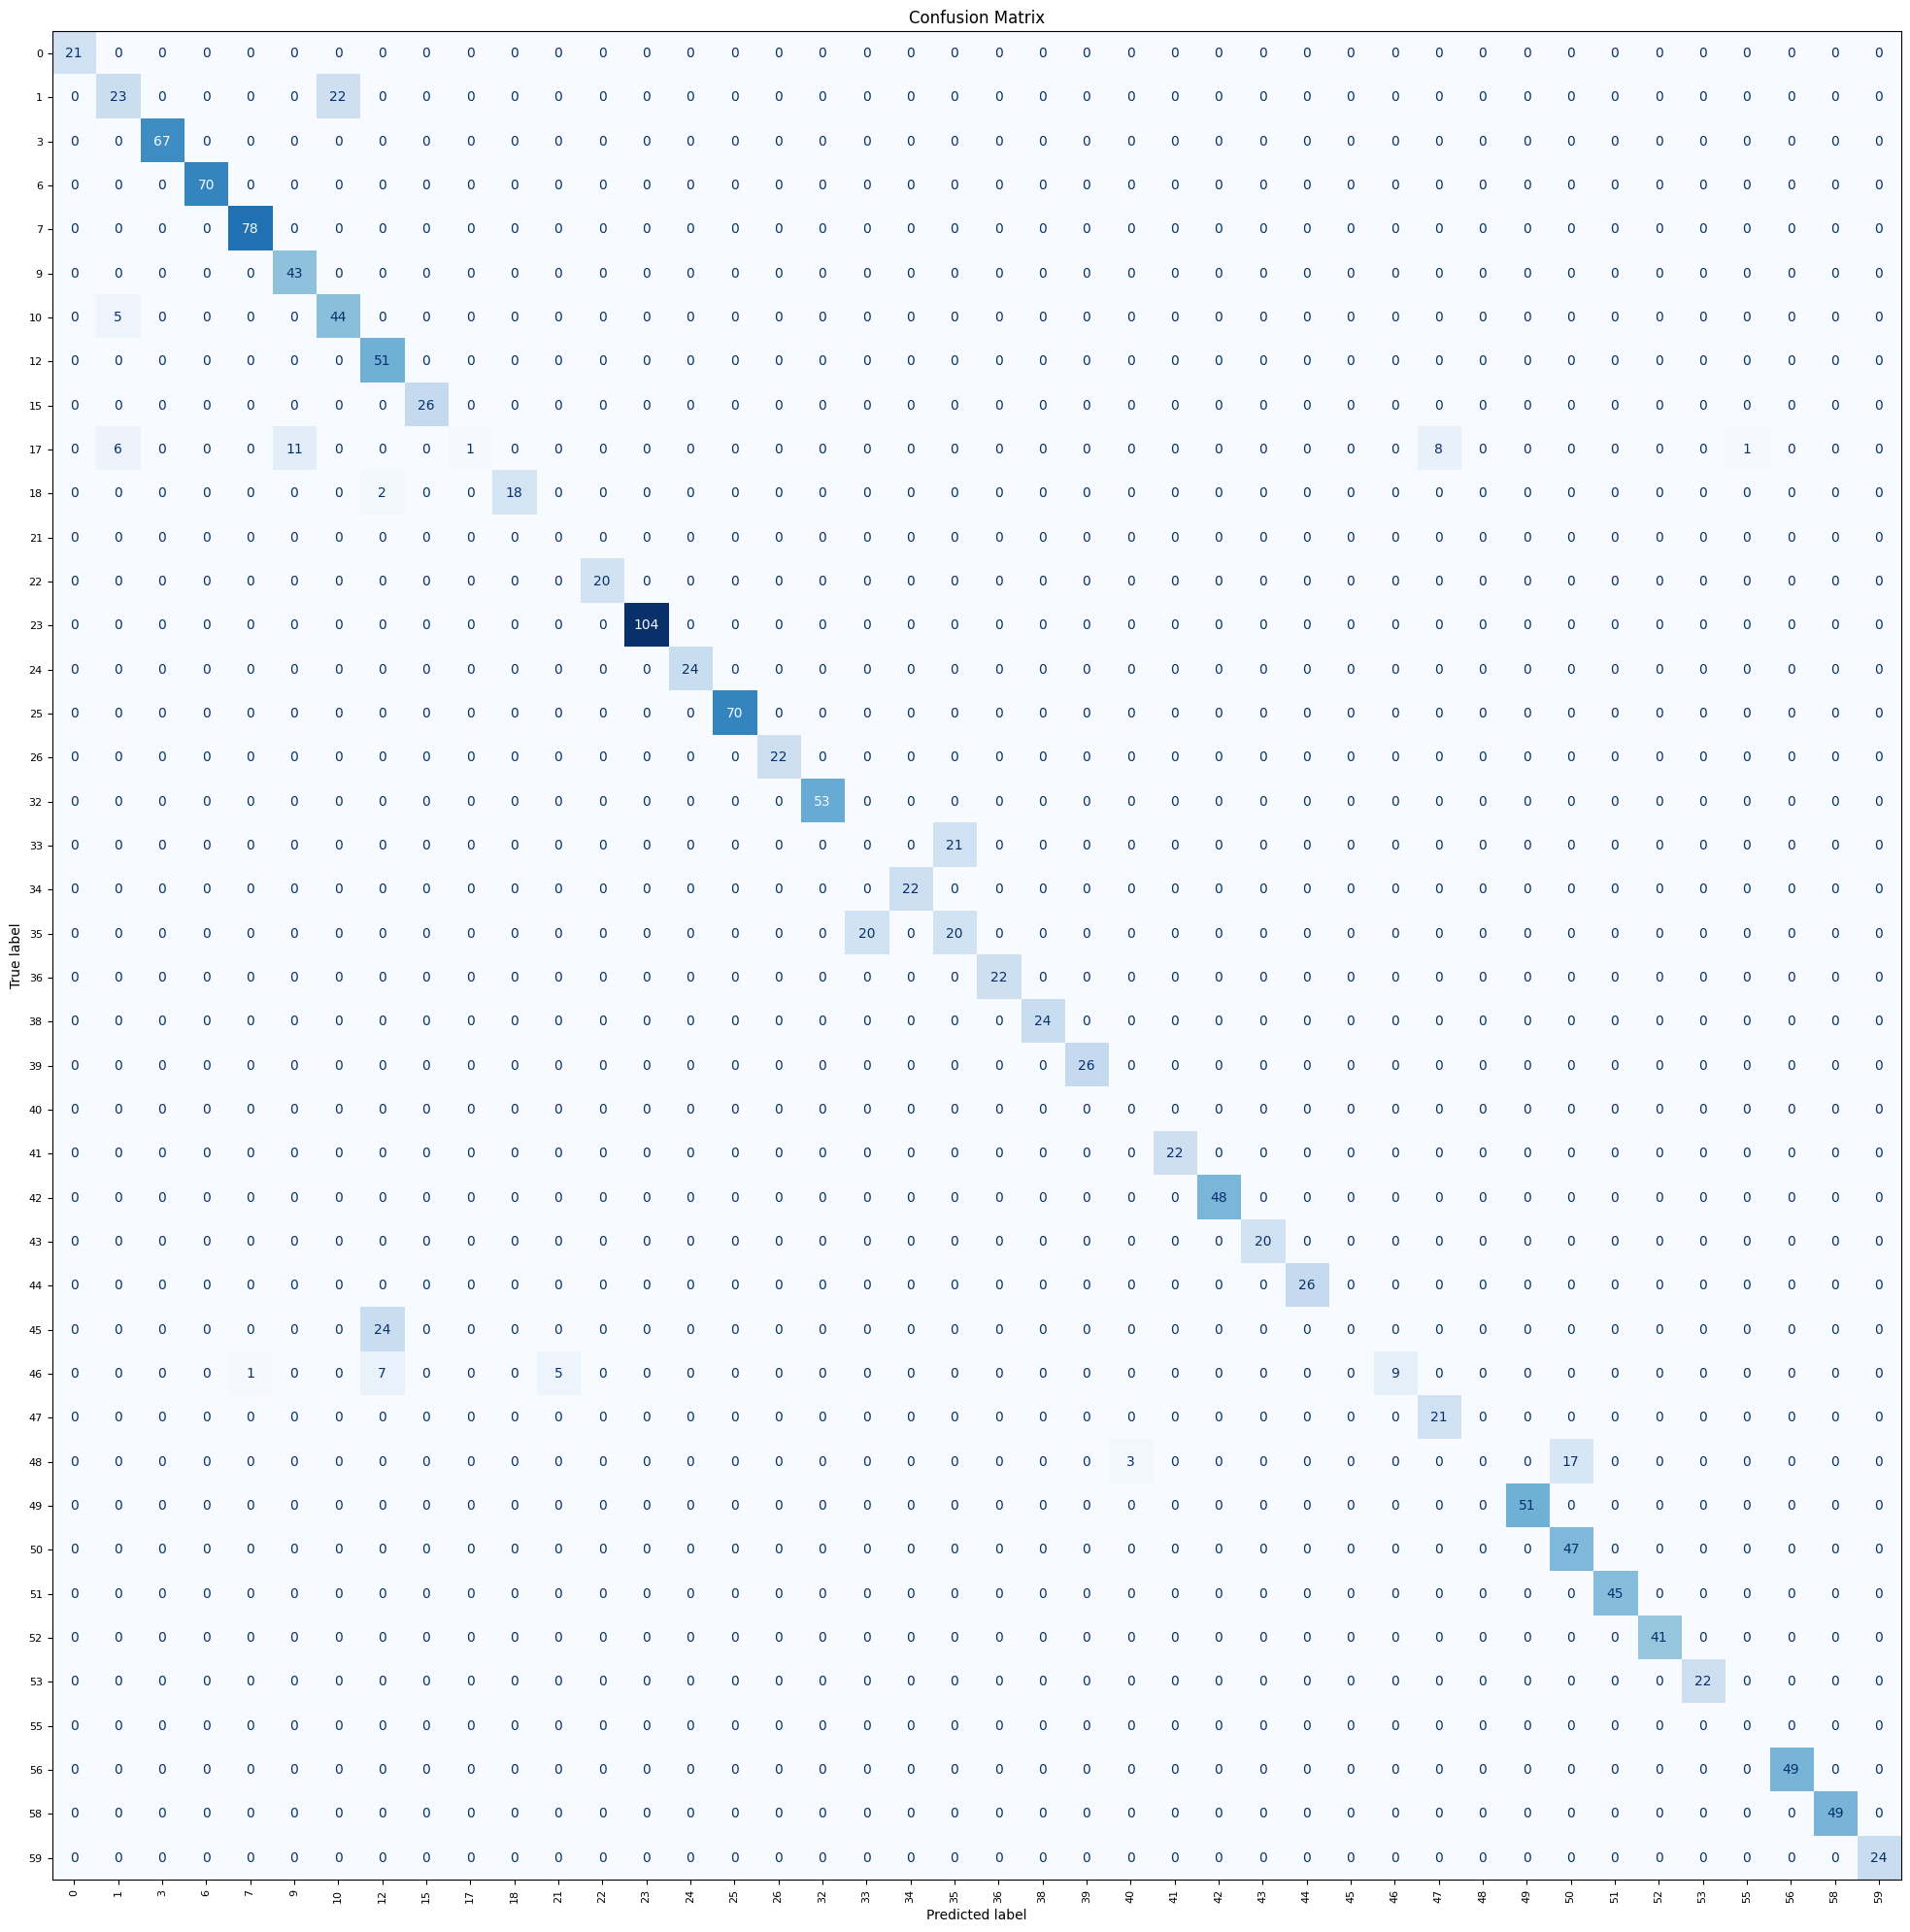

{'accuracy': 0.8963414634146342,
 'predicted_labels': array([ 0,  0,  0, ..., 59, 59, 59]),
 'true_labels': 86       0
 87       0
 88       0
 89       0
 90       0
         ..
 7875    59
 7876    59
 7877    59
 7878    59
 7879    59
 Name: genus_species_label, Length: 1476, dtype: int64}

In [30]:
print("---------------------------- EVALUACIÓN A NIVEL DE GÉNERO Y ESPECIE CON RANDOM FOREST -----------------------------------")
evaluate_knn_classifier(spectrum_test, genus_species_label_test, random_forest)

In [39]:
#export model
joblib.dump(random_forest, "random_forest_model.pkl")

['random_forest_model.pkl']

In [37]:
import shap
import numpy as np

# Convertir los datos a numpy arrays con el mismo tipo que el entrenamiento (float64)
X_train = x_train_smote
X_test = spectrum_test

# Filtrar muestras con etiqueta 6
mask_label_6 = genus_species_label_test.values.flatten() == 6
X_test_label_6 = X_test[mask_label_6].astype(np.float64)  # Convertimos a float64

if X_test_label_6.shape[0] > 0:
    # Usamos PermutationExplainer en lugar de TreeExplainer
    explainer = shap.Explainer(random_forest.predict, X_train[:100], algorithm="permutation")

    # Explicar solo 3 muestras con la etiqueta 6
    shap_values_label_6 = explainer(X_test_label_6[:3], max_evals=6001)

    # Mostrar gráfico de valores SHAP
    shap.summary_plot(shap_values_label_6, X_test_label_6[:3], feature_names=[f"f{i}" for i in range(X_train.shape[1])])
else:
    print("No hay muestras con la etiqueta 6 disponibles.")

MemoryError: Unable to allocate 13.4 GiB for an array with shape (600100, 3000) and data type float64

## Buscando mejores hiperparámetros para Random Forest con Grid Search

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definir el conjunto de hiperparámetros
param_grid = {
    'n_estimators': [10, 20, 50, 100],  # Número de árboles
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras en una hoja
    'max_features': ['sqrt', 'log2'],  # Número de características consideradas en cada árbol
    'bootstrap': [True, False]  # Si se usa muestreo con reemplazo
}

# Inicializar el modelo
random_forest = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 folds
    n_jobs=-1,  # Usar todos los núcleos disponibles
    verbose=2,  # Mostrar progreso
    scoring='accuracy'  # Usar precisión como métrica
)

# Ejecutar la búsqueda en los datos de entrenamiento
grid_search.fit(x_train_smote, genus_species_smote)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor precisión obtenida:", grid_search.best_score_)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


KeyboardInterrupt: 